In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import timedelta
from collections import Counter
from prophet import Prophet
import seaborn as sns

d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
data = pd.read_csv('web-traffic-time-series-forecasting/train_2.csv/train_2.csv').fillna(0)
data.head()

Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...         0.0         0.0   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0         9.0         9.0        22.0   
1        15.0        18.0        11.0        13.0        22.0        11.0   
2         1.0         1.0         0.0         4.0         0.0         3.0   
3        10.0        94.0         4.0        26.0        14.0         9.0   
4         0.0         0.0         0.0         0.0         0.0         0.0   

   2015-07-09  ...  2017-09-01  2017-09-02  2017-09-03  2017-09-04  \
0        26.0  ...        19.0        33.0        33.0        18.0   
1        10.0  ...        32.0        30.0        11.0        19.0   
2         4.0  ...         6.0         6.0         7.0         2.0   
3        11.0  ...         7.0        19.0        19.0         9.0   
4         0.0  ...        16.0        16.0        19.0         9.0   

   2017-09-05  2017-09-06  2017-09-07  2017-09-08  2017-09-09  2017-09-10  
0        16.0        27.0        29.0        23.0        54.0        38.0  
1        54.0        25.0        26.0        23.0        13.0        81.0  
2         4.0         7.0         3.0         4.0         7.0         6.0  
3         6.0        16.0        19.0        30.0        38.0         4.0  
4        20.0        23.0        28.0        14.0         8.0         7.0  

[5 rows x 804 columns]

In [3]:
print(data.shape)

(145063, 804)


In [3]:
#Select only data up to 31/07/2017
date_cols = pd.to_datetime(data.columns[1:], errors="coerce")
train_mask = [True] + list(date_cols <= "2017-07-31")  # include first column
train = data.loc[:, train_mask]
train = train.copy()

train_dates = date_cols[date_cols <= "2017-07-31"]

In [4]:
test_mask = [True] + list((date_cols >= "2017-08-01") & (date_cols <= "2017-09-10"))
test = data.loc[:, test_mask]
test = test.copy()

test_dates = date_cols[(date_cols >= "2017-08-01") & (date_cols <= "2017-09-10")]

In [6]:
test.head()

Page  2017-08-01  2017-08-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        20.0        46.0   
1             2PM_zh.wikipedia.org_all-access_spider        18.0        39.0   
2              3C_zh.wikipedia.org_all-access_spider         0.0        22.0   
3         4minute_zh.wikipedia.org_all-access_spider        14.0        37.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...        14.0        40.0   

   2017-08-03  2017-08-04  2017-08-05  2017-08-06  2017-08-07  2017-08-08  \
0        24.0        22.0        22.0        11.0        25.0        45.0   
1        20.0        31.0        19.0         7.0        11.0        20.0   
2         8.0         4.0         3.0         1.0         3.0         7.0   
3        14.0        12.0        13.0        11.0        10.0        14.0   
4        39.0        66.0       114.0        19.0        29.0        12.0   

   2017-08-09  ...  2017-09-01  2017-09-02  2017-09-03  2017-09-04  \
0        39.0  ...        19.0        33.0        33.0        18.0   
1        13.0  ...        32.0        30.0        11.0        19.0   
2         3.0  ...         6.0         6.0         7.0         2.0   
3        15.0  ...         7.0        19.0        19.0         9.0   
4        11.0  ...        16.0        16.0        19.0         9.0   

   2017-09-05  2017-09-06  2017-09-07  2017-09-08  2017-09-09  2017-09-10  
0        16.0        27.0        29.0        23.0        54.0        38.0  
1        54.0        25.0        26.0        23.0        13.0        81.0  
2         4.0         7.0         3.0         4.0         7.0         6.0  
3         6.0        16.0        19.0        30.0        38.0         4.0  
4        20.0        23.0        28.0        14.0         8.0         7.0  

[5 rows x 42 columns]

C:\Users\arsen\AppData\Local\Temp\ipykernel_2868\81410149.py:23: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from current font.
  plt.tight_layout()
C:\Users\arsen\AppData\Local\Temp\ipykernel_2868\81410149.py:23: UserWarning: Glyph 39791 (\N{CJK UNIFIED IDEOGRAPH-9B6F}) missing from current font.
  plt.tight_layout()
C:\Users\arsen\AppData\Local\Temp\ipykernel_2868\81410149.py:23: UserWarning: Glyph 38307 (\N{CJK UNIFIED IDEOGRAPH-95A3}) missing from current font.
  plt.tight_layout()
C:\Users\arsen\AppData\Local\Temp\ipykernel_2868\81410149.py:23: UserWarning: Glyph 33609 (\N{CJK UNIFIED IDEOGRAPH-8349}) missing from current font.
  plt.tight_layout()
C:\Users\arsen\AppData\Local\Temp\ipykernel_2868\81410149.py:23: UserWarning: Glyph 34905 (\N{CJK UNIFIED IDEOGRAPH-8859}) missing from current font.
  plt.tight_layout()
C:\Users\arsen\AppData\Local\Temp\ipykernel_2868\81410149.py:23: UserWarning: Glyph 36947 (\N{CJK UNIFIED IDEOGRAPH-9053}) missing from current f

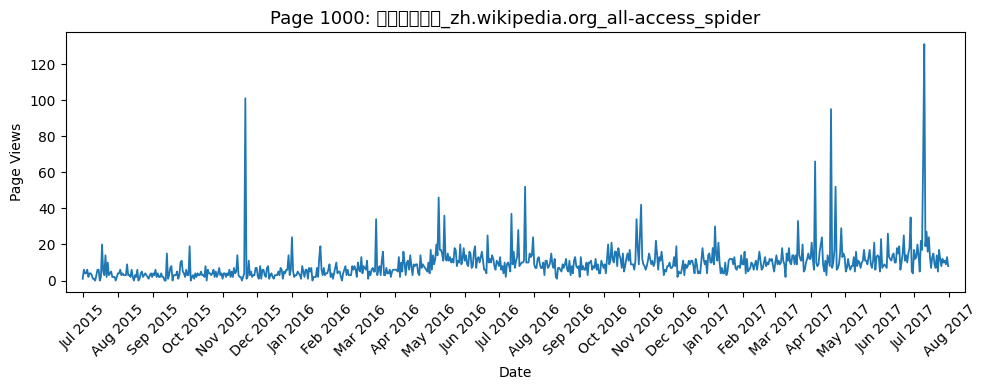

In [5]:

def plot_entry(idx):
    traindata = train.iloc[idx, 1:]  # Skip the 'Page' column, get all time series data
    page_name = train.iloc[idx, 0]   # Get the page name

    # Create the plot
    plt.figure(figsize=(10, 4))
    plt.plot(train_dates, traindata.values, linewidth=1.3)
    plt.title(f"Page {idx}: {page_name}", fontsize=13)
    plt.xlabel('Date')
    plt.ylabel('Page Views')
    #plt.grid(True, alpha=0.3)


    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    plt.xticks(rotation=45)

    delta = timedelta(days=15)
    ax.set_xlim([train_dates.min() - delta, train_dates.max() + delta])

    plt.tight_layout()
    plt.show()

plot_entry(1000)



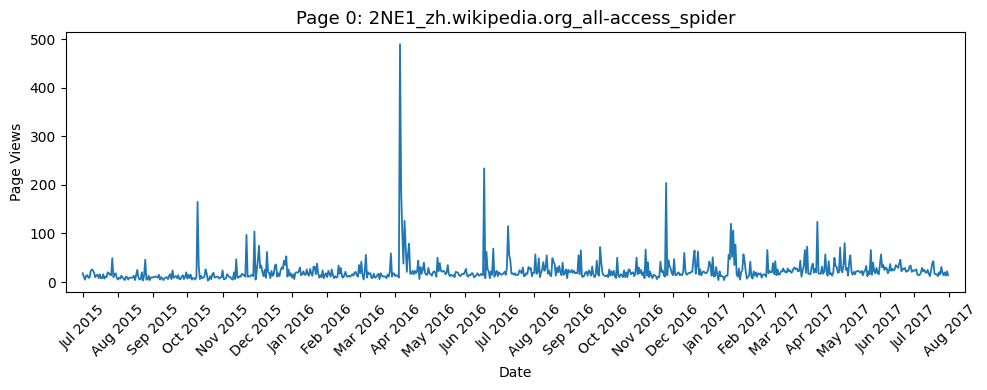

In [ ]:
def plot_and_save_entry(idx):
    """
    Plot time series for a given index and save the image to plots folder
    
    Parameters:
    idx (int): Index of the row to plot
    """
    
    # Get the data and page name
    data = train.iloc[idx, 1:,]  # Skip the 'Page' column, get all time series data
    page_name = train.iloc[idx, 0]   # Get the page name
    
    # Create the plot
    plt.figure(figsize=(10, 4))
    plt.plot(train_dates, data.values, linewidth=1.3)
    plt.title(f"Page {idx}: {page_name}", fontsize=13)
    plt.xlabel('Date')
    plt.ylabel('Page Views')

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    plt.xticks(rotation=45)

    delta = timedelta(days=15)
    ax.set_xlim([train_dates.min() - delta, train_dates.max() + delta])

    plt.tight_layout()
    
    # Save the plot
    filename = f'plots/plot_{idx}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')


plot_and_save_entry(0)  # Plot and save the first time series

C:\Users\arsen\AppData\Local\Temp\ipykernel_2996\155677124.py:29: UserWarning: Glyph 39321 (\N{CJK UNIFIED IDEOGRAPH-9999}) missing from current font.
  plt.tight_layout()
C:\Users\arsen\AppData\Local\Temp\ipykernel_2996\155677124.py:29: UserWarning: Glyph 21513 (\N{CJK UNIFIED IDEOGRAPH-5409}) missing from current font.
  plt.tight_layout()
C:\Users\arsen\AppData\Local\Temp\ipykernel_2996\155677124.py:29: UserWarning: Glyph 22763 (\N{CJK UNIFIED IDEOGRAPH-58EB}) missing from current font.
  plt.tight_layout()
C:\Users\arsen\AppData\Local\Temp\ipykernel_2996\155677124.py:33: UserWarning: Glyph 39321 (\N{CJK UNIFIED IDEOGRAPH-9999}) missing from current font.
  plt.savefig(filename, dpi=300, bbox_inches='tight')
C:\Users\arsen\AppData\Local\Temp\ipykernel_2996\155677124.py:33: UserWarning: Glyph 21513 (\N{CJK UNIFIED IDEOGRAPH-5409}) missing from current font.
  plt.savefig(filename, dpi=300, bbox_inches='tight')
C:\Users\arsen\AppData\Local\Temp\ipykernel_2996\155677124.py:33: UserWarn

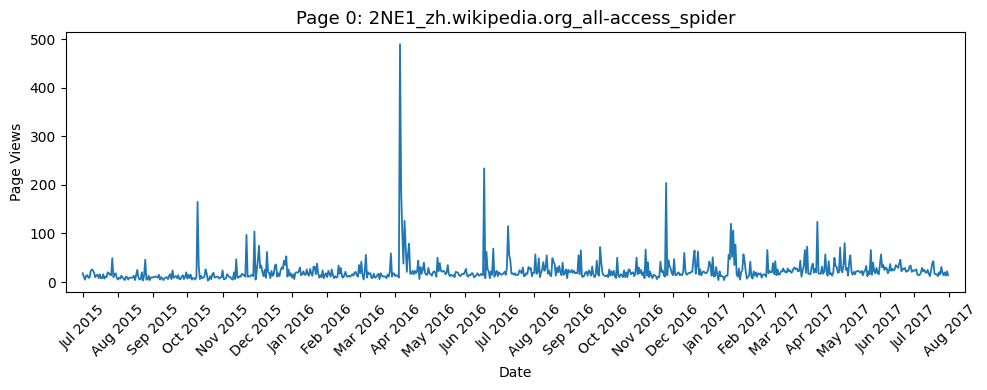

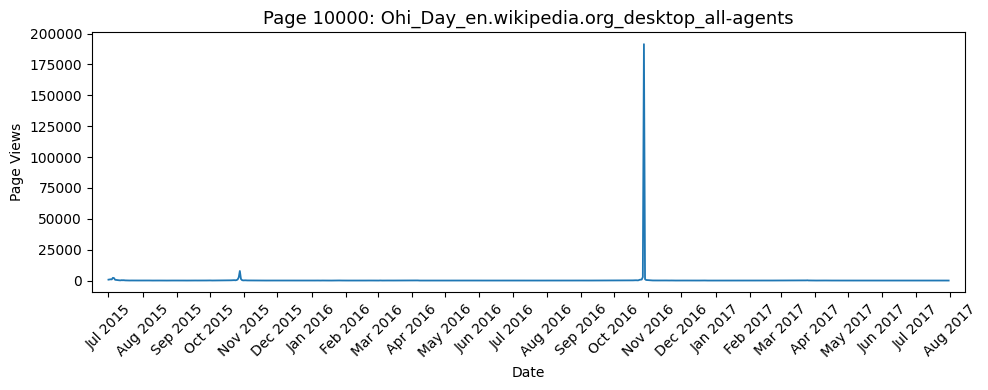

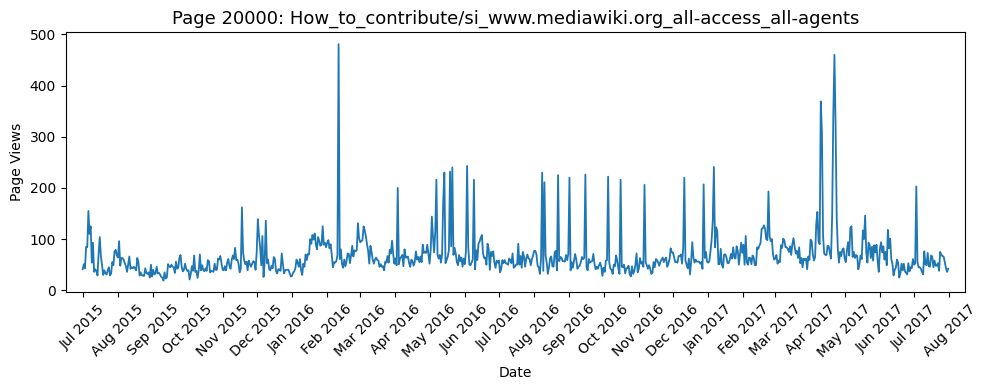

d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 39321 (\N{CJK UNIFIED IDEOGRAPH-9999}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21513 (\N{CJK UNIFIED IDEOGRAPH-5409}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22763 (\N{CJK UNIFIED IDEOGRAPH-58EB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


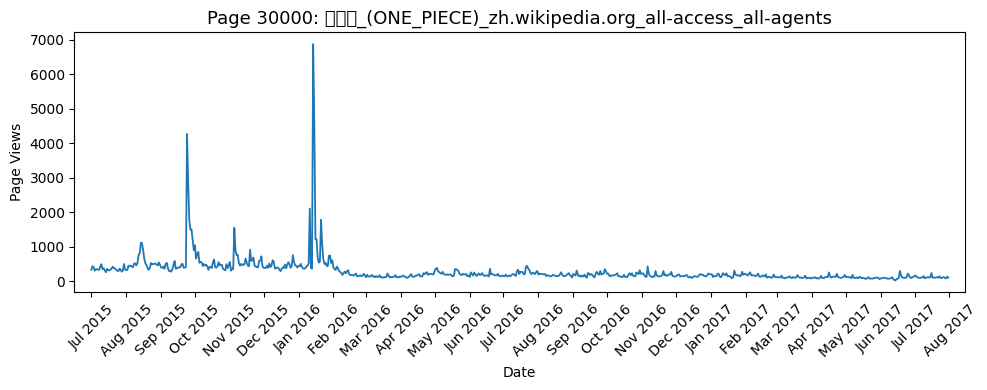

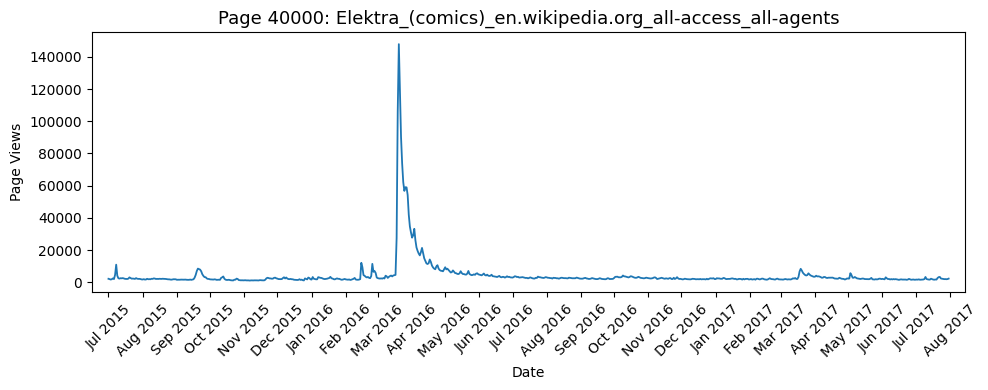

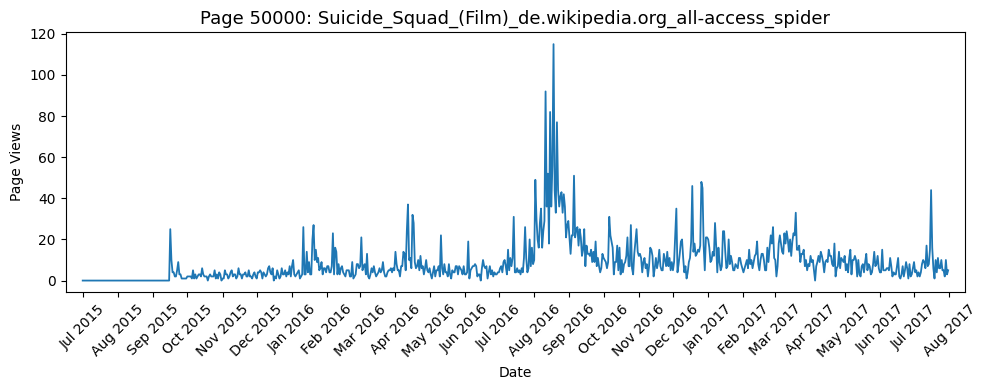

d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12418 (\N{HIRAGANA LETTER MO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12364 (\N{HIRAGANA LETTER GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


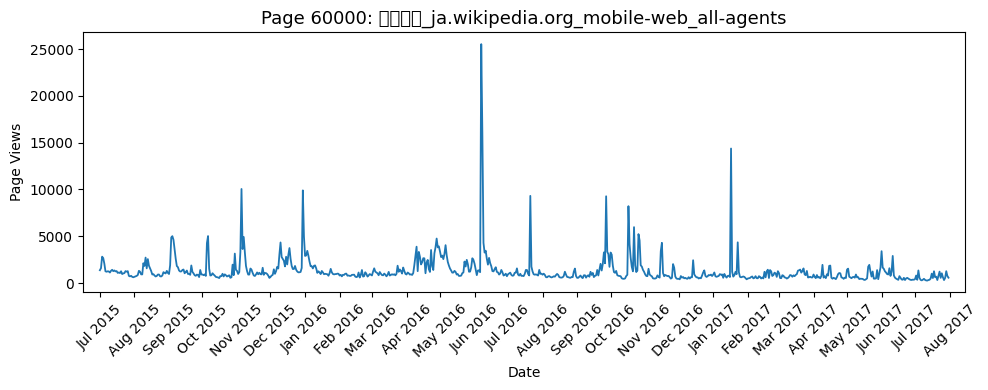

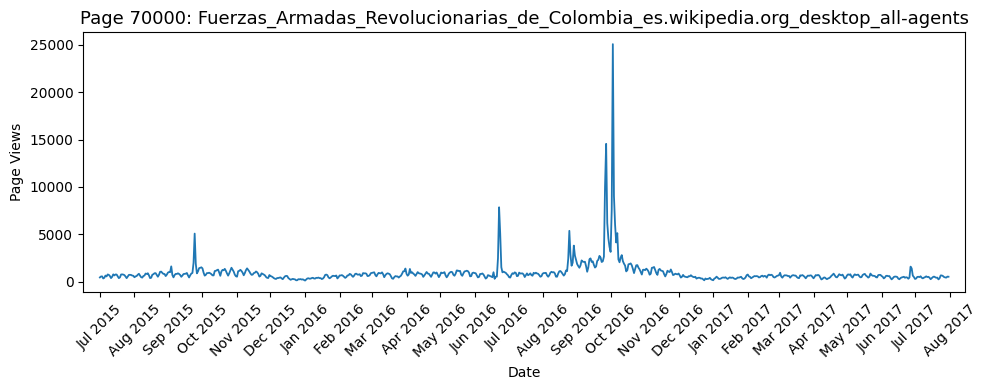

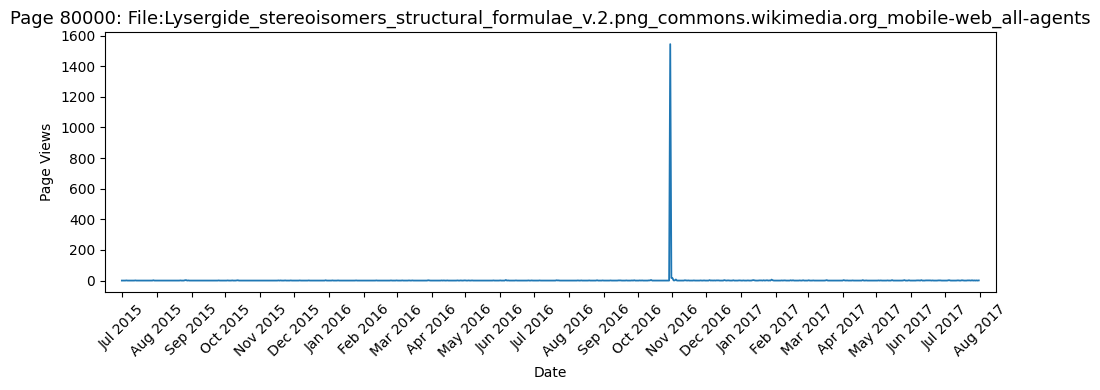

d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12501 (\N{KATAKANA LETTER HU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12451 (\N{KATAKANA LETTER SMALL I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-ana

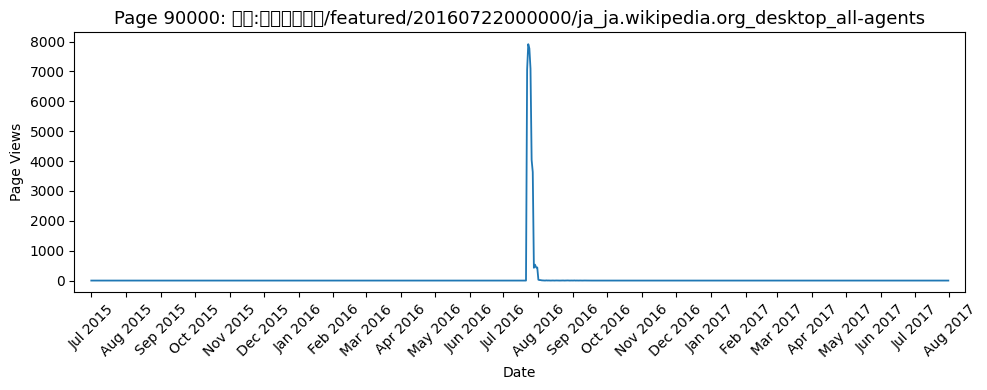

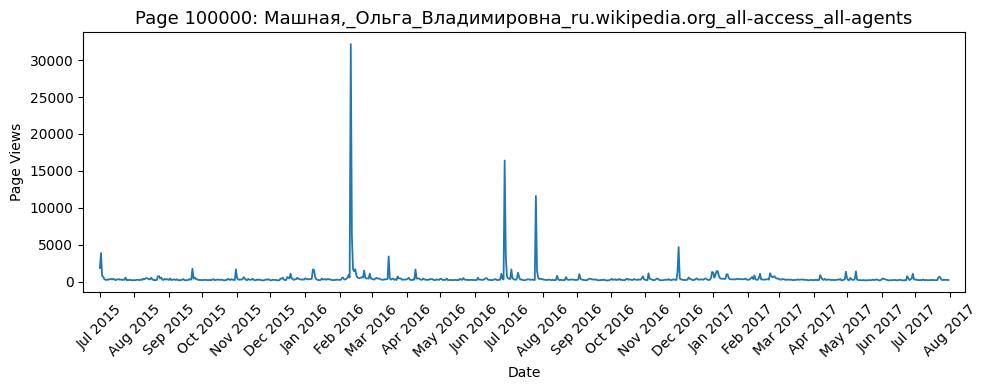

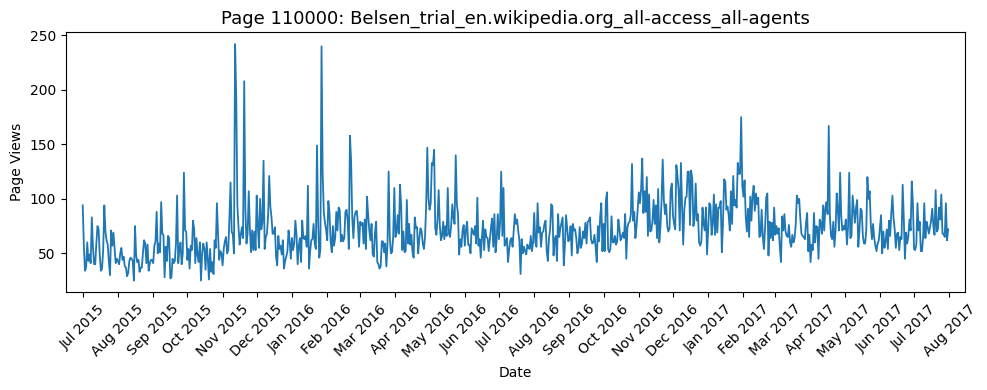

d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26519 (\N{CJK UNIFIED IDEOGRAPH-6797}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24736 (\N{CJK UNIFIED IDEOGRAPH-60A0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12450 (\N{KATAKANA LETTER A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Dokumenty\Internship\Time Series\time-series-a

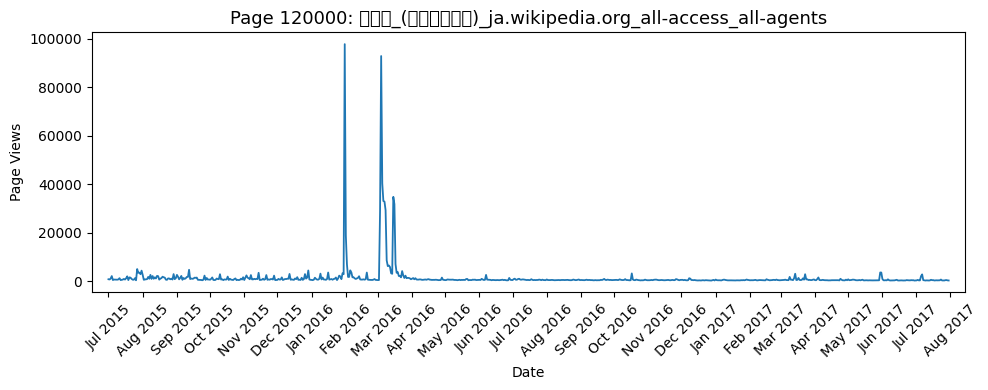

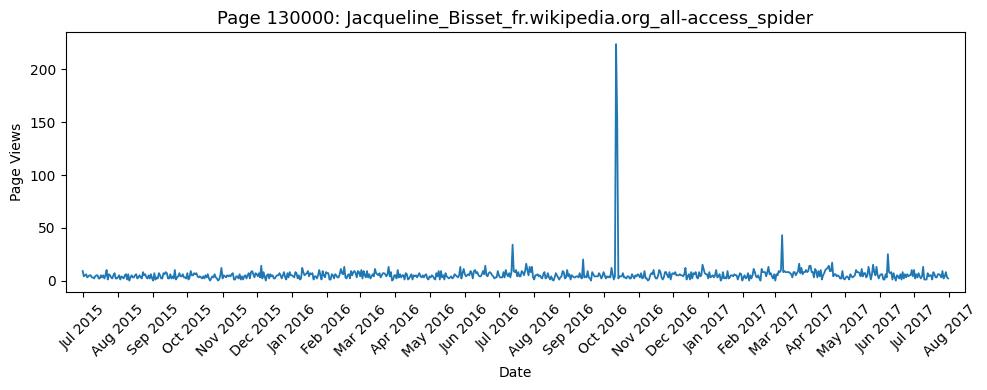

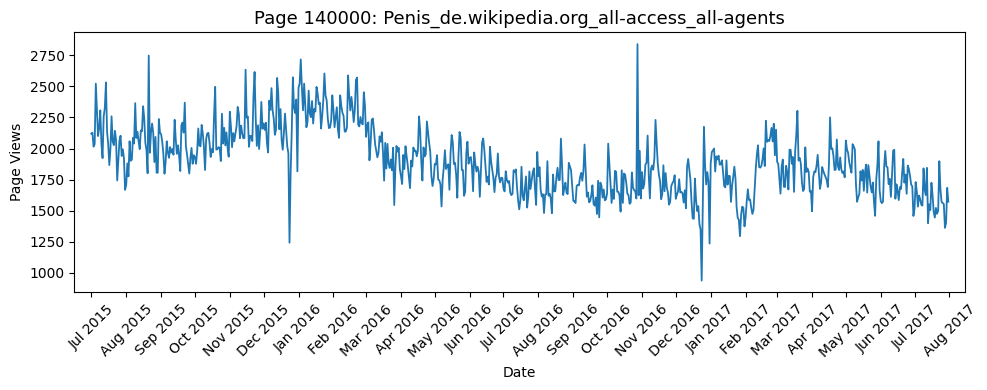

In [10]:
for i in range(0, 15):
    plot_and_save_entry(i*10000) 

In [5]:
def get_language(page):
    # Regex with a capturing group for the language code
    match = re.search(r'([a-z]{2})\.wikipedia\.org', page)
    if match:
        return match.group(1)  # get the captured language code
    return 'na'

train.loc[:, 'lang'] = train['Page'].map(get_language)

test.loc[:, 'lang'] = test['Page'].map(get_language)

print(Counter(train.lang))
print(Counter(test.lang))

Counter({'en': 24108, 'ja': 20431, 'de': 18547, 'na': 17855, 'fr': 17802, 'zh': 17229, 'ru': 15022, 'es': 14069})
Counter({'en': 24108, 'ja': 20431, 'de': 18547, 'na': 17855, 'fr': 17802, 'zh': 17229, 'ru': 15022, 'es': 14069})


In [6]:
lang_sets = {
    lang: train[train.lang == lang].iloc[:, 0:-1].copy()
    for lang in train['lang'].unique()
}

avg_views_by_lang = {
    lang: df.iloc[:, 1:-1].sum(axis=0) / df.shape[0]
    for lang, df in lang_sets.items()
}

In [7]:
lang_sets_test = {
    lang: test[test.lang == lang].iloc[:, 0:-1].copy()
    for lang in test['lang'].unique()
}

avg_views_by_lang_test = {
    lang: df.iloc[:, 1:].sum(axis=0) / df.shape[0]
    for lang, df in lang_sets_test.items()
}

In [8]:
for lang in lang_sets:
    lang_sets[lang].loc[:, 'avg_views'] = lang_sets[lang].iloc[:, 1:].mean(axis=1)

In [9]:
for lang in lang_sets:
    lang_sets[lang] = lang_sets[lang].sort_values('avg_views', ascending=False).reset_index(drop=True)

In [68]:
lang_sets['en'].head(30)

Page  2015-07-01  2015-07-02  \
0    Main_Page_en.wikipedia.org_all-access_all-agents  20381245.0  20752194.0   
1       Main_Page_en.wikipedia.org_desktop_all-agents  11952559.0  12344021.0   
2    Main_Page_en.wikipedia.org_mobile-web_all-agents   8039732.0   8018607.0   
3   Special:Search_en.wikipedia.org_all-access_all...   2034850.0   1984412.0   
4   Special:Search_en.wikipedia.org_desktop_all-ag...   1628266.0   1576720.0   
5   Special:Search_en.wikipedia.org_mobile-web_all...    406584.0    407692.0   
6   Special:Book_en.wikipedia.org_all-access_all-a...    175242.0    114676.0   
7    Special:Book_en.wikipedia.org_desktop_all-agents    174903.0    113999.0   
8   Special:Search_en.wikipedia.org_all-access_spider       398.0      1518.0   
9        Main_Page_en.wikipedia.org_all-access_spider     17207.0     14756.0   
10     404.php_en.wikipedia.org_all-access_all-agents         5.0       100.0   
11        404.php_en.wikipedia.org_desktop_all-agents         5.0       100.0   
12  Donald_Trump_en.wikipedia.org_all-access_all-a...     82159.0     83458.0   
13    XHamster_en.wikipedia.org_all-access_all-agents      3009.0      3034.0   
14    XHamster_en.wikipedia.org_mobile-web_all-agents      1776.0      1742.0   
15  Special:RecentChanges_en.wikipedia.org_all-acc...    167339.0    207043.0   
16  Special:RecentChanges_en.wikipedia.org_desktop...    166252.0    205914.0   
17  Special:CreateAccount_en.wikipedia.org_all-acc...         0.0         0.0   
18  Special:CreateAccount_en.wikipedia.org_desktop...         0.0         0.0   
19  Donald_Trump_en.wikipedia.org_mobile-web_all-a...     44981.0     44451.0   
20  Web_scraping_en.wikipedia.org_all-access_all-a...       874.0       968.0   
21   Web_scraping_en.wikipedia.org_desktop_all-agents       774.0       829.0   
22  Special:Watchlist_en.wikipedia.org_all-access_...     78282.0     74246.0   
23  Special:Watchlist_en.wikipedia.org_desktop_all...     77138.0     73280.0   
24  User:GoogleAnalitycsRoman/google-api_en.wikipe...    258566.0    228871.0   
25   Donald_Trump_en.wikipedia.org_desktop_all-agents     35886.0     37554.0   
26       AMGTV_en.wikipedia.org_all-access_all-agents        44.0        62.0   
27  Proyecto_40_en.wikipedia.org_all-access_all-ag...      1157.0      1234.0   
28    Proyecto_40_en.wikipedia.org_desktop_all-agents      1106.0      1131.0   
29  Special:RecentChangesLinked_en.wikipedia.org_a...     37094.0      4410.0   

    2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0   19573967.0  20439645.0  20772109.0  22544669.0  21210887.0  19107911.0   
1   11195848.0  11982470.0  12379684.0  14164829.0  12917172.0  11089923.0   
2    7980511.0   8024814.0   7929962.0   7959839.0   7892357.0   7607871.0   
3    1763117.0   1620136.0   1766701.0   2108408.0   2118720.0   2052391.0   
4    1375372.0   1226739.0   1336675.0   1699242.0   1709755.0   1653199.0   
5     387745.0    393397.0    430026.0    409166.0    408965.0    399192.0   
6      98461.0    102297.0    128310.0    119764.0    161174.0    196632.0   
7      98127.0    102158.0    127525.0    119101.0    159949.0    194830.0   
8        547.0       598.0       512.0       708.0       849.0      2916.0   
9      18837.0     37468.0     21366.0     26924.0     29064.0     19440.0   
10         1.0         0.0         7.0         2.0         5.0         6.0   
11         1.0         0.0         7.0         2.0         5.0         6.0   
12     55615.0     43865.0     42220.0     38412.0     44158.0     48631.0   
13      2799.0      2560.0      2897.0      2879.0      3214.0      3434.0   
14      1751.0      1549.0      1709.0      1718.0      2017.0      2235.0   
15    151859.0    121738.0    118392.0    111983.0    216144.0    215209.0   
16    150886.0    121018.0    117389.0    111148.0    214943.0    214163.0   
17         0.0         0.0         0.0         0.0         0.0         0.0   
18         0.0         0.0         0.0         0.0     

In [10]:
def plot_entry_lang(lang,idx):
    pagedata = lang_sets[lang].iloc[idx, 1:-1]  # Skip the 'Page' column, get all time series data
    page_name = lang_sets[lang].iloc[idx, 0]   # Get the page name

    labels={'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
       }

    # Create the plot
    plt.figure(figsize=(10, 4))
    plt.plot(train_dates, pagedata.values, linewidth=1.3)
    plt.title(f"{labels.get(lang, lang)} page {idx}: {page_name}", fontsize=13)
    plt.xlabel('Date')
    plt.ylabel('Page Views')
    #plt.grid(True, alpha=0.3)


    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    plt.xticks(rotation=45)

    delta = timedelta(days=15)
    ax.set_xlim([train_dates.min() - delta, train_dates.max() + delta])

    plt.tight_layout()
    plt.show()

C:\Users\arsen\AppData\Local\Temp\ipykernel_2868\3529109298.py:28: UserWarning: Glyph 12513 (\N{KATAKANA LETTER ME}) missing from current font.
  plt.tight_layout()
C:\Users\arsen\AppData\Local\Temp\ipykernel_2868\3529109298.py:28: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from current font.
  plt.tight_layout()
C:\Users\arsen\AppData\Local\Temp\ipykernel_2868\3529109298.py:28: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from current font.
  plt.tight_layout()
C:\Users\arsen\AppData\Local\Temp\ipykernel_2868\3529109298.py:28: UserWarning: Glyph 12506 (\N{KATAKANA LETTER PE}) missing from current font.
  plt.tight_layout()
C:\Users\arsen\AppData\Local\Temp\ipykernel_2868\3529109298.py:28: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from current font.
  plt.tight_layout()
C:\Users\arsen\AppData\Local\Temp\ipykernel_2868\3529109298.py:28: UserWarning: Glyph 12472 (\N{KATAKANA LETTER ZI}) missing from current font.
  plt.tight_l

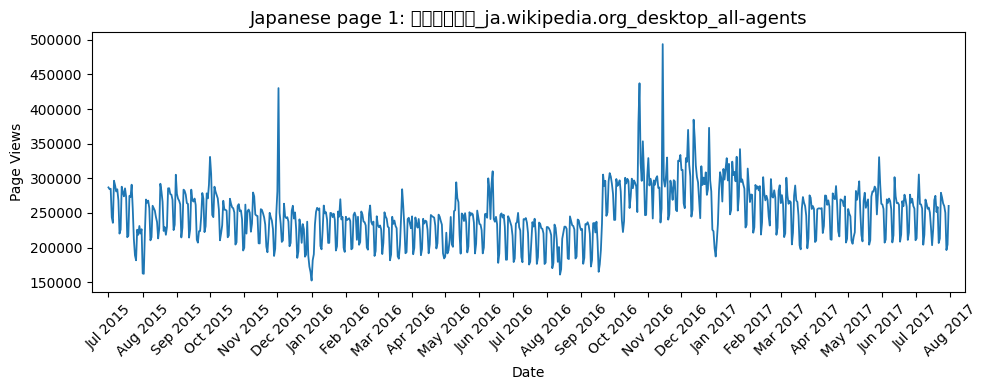

In [62]:
plot_entry_lang('ja',1)

In [11]:
index_to_page_dict = {
    lang: pd.Series(df["Page"].values, index=df.index)
    for lang, df in lang_sets.items()
}

# For each language, create a dict: page_name -> original index
page_to_index_dict = {
    lang: dict(zip(index_to_page_dict[lang].values, index_to_page_dict[lang].index))
    for lang in index_to_page_dict
}

In [12]:
def get_normalized_weekly_pattern(lang, dfs, page_to_index_dict):
    """
    Compute normalized weekday patterns for a given language dataset, keeping original index.
    
    Parameters
    ----------
    lang : str
        Language code (e.g., "en", "de").
    dfs : dict
        Dictionary mapping language codes to their corresponding DataFrames.
        Each DataFrame should have:
          - "Page" column
          - daily view columns (date strings as column names)
          - "avg_views" column (mean per page)
    page_to_index_dict : dict
        Dictionary mapping language code -> {page_name: original_index}
    
    Returns
    -------
    pd.DataFrame
        DataFrame with:
          - rows = original DataFrame indices
          - columns = Monday ... Sunday
          - values = normalized weekday averages (relative to page's average)
    """
    
    # 1. Select the DataFrame for this language
    data = dfs[lang]

    # 2. Melt into long format
    df_long = data.melt(
        id_vars=["Page", "avg_views"],
        var_name="date",
        value_name="views"
    )
    df_long["date"] = pd.to_datetime(df_long["date"], errors="coerce")
    df_long["weekday"] = df_long["date"].dt.day_name()

    # 3. Compute mean views per (Page, weekday)
    avg_by_dow = df_long.groupby(["Page", "weekday"])["views"].mean().reset_index()

    # 4. Merge overall average for normalization
    avg_by_dow = avg_by_dow.merge(
        data[["Page", "avg_views"]],
        on="Page",
        how="left"
    )
    avg_by_dow["normalized"] = avg_by_dow["views"] / avg_by_dow["avg_views"]

    # 5. Map Page to original index using precomputed dictionary (fast)
    avg_by_dow["original_index"] = avg_by_dow["Page"].map(page_to_index_dict[lang])

    # 6. Pivot so rows = original index, columns = weekdays (Mon-Sun)
    weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    normalized_pattern = (
        avg_by_dow.pivot(index="original_index", columns="weekday", values="normalized")
        .reindex(columns=weekday_order)
    )

    return normalized_pattern

In [13]:
week_patterns = {lang: get_normalized_weekly_pattern(lang, lang_sets, page_to_index_dict) for lang in lang_sets}

In [27]:
print(week_patterns["en"].head(30))

weekday           Monday   Tuesday  Wednesday  Thursday    Friday  Saturday  \
original_index                                                                
0               1.084690  1.032767   1.007705  0.972930  0.906976  0.984841   
1               1.115765  1.047434   1.010577  0.964583  0.882527  0.976857   
2               0.991571  0.994641   1.004699  1.005825  0.983097  1.003142   
3               1.034268  1.066109   1.100801  1.056825  0.967910  0.861905   
4               1.045780  1.080901   1.126731  1.065994  0.968996  0.830383   
5               1.000797  1.023122   1.025429  1.030201  0.964757  0.953516   
6               1.063387  1.031155   1.026449  1.078781  1.011869  0.909148   
7               1.063534  1.031684   1.026899  1.078760  1.011636  0.908714   
8               0.823726  0.977655   1.079886  1.160095  1.043300  0.942899   
9               0.896143  0.971426   1.004455  1.035516  0.996013  1.060124   
10              0.784628  1.452254   1.074009  1.024

In [15]:
prop_pages_above_avg = {}

for lang, data in week_patterns.items():
    # 1. Count pages with normalized views > 1 per weekday
    above_1 = (data > 1).sum(axis=0)
    
    # 2. Normalize by total number of pages (to get proportion)
    above_1 = above_1 / len(data)
    
    # 3. Store result
    prop_pages_above_avg[lang] = above_1

# --- Example: print summaries ---
for lang, s in prop_pages_above_avg.items():
    print(f"\n=== {lang} ===")
    print(s)


=== zh ===
weekday
Monday       0.431540
Tuesday      0.354751
Wednesday    0.341807
Thursday     0.309072
Friday       0.300250
Saturday     0.539788
Sunday       0.608799
dtype: float64

=== fr ===
weekday
Monday       0.468768
Tuesday      0.334176
Wednesday    0.473486
Thursday     0.440962
Friday       0.196944
Saturday     0.386417
Sunday       0.583586
dtype: float64

=== en ===
weekday
Monday       0.539655
Tuesday      0.442135
Wednesday    0.405384
Thursday     0.350465
Friday       0.264394
Saturday     0.440144
Sunday       0.463083
dtype: float64

=== na ===
weekday
Monday       0.511901
Tuesday      0.448670
Wednesday    0.421507
Thursday     0.438365
Friday       0.474209
Saturday     0.430244
Sunday       0.377429
dtype: float64

=== ru ===
weekday
Monday       0.481494
Tuesday      0.497404
Wednesday    0.509653
Thursday     0.343430
Friday       0.216682
Saturday     0.390494
Sunday       0.562641
dtype: float64

=== de ===
weekday
Monday       0.516040
Tuesday      

In [18]:
weekday_ranks = {}

for lang, data in week_patterns.items():
    # 1. Compute proportion of pages with normalized views > 1 per weekday
    above_1 = (data > 1).sum(axis=0) / len(data)

    # 2. Rank weekdays (1 = highest proportion)
    rank = above_1.rank(method="dense", ascending=False).astype(int)

    # 3. Store in dictionary
    weekday_ranks[lang] = rank

# 4. Combine into one DataFrame
weekday_rank_table = pd.DataFrame(weekday_ranks)

# 5. Reorder weekdays in standard order
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekday_rank_table = weekday_rank_table.reindex(weekday_order)

# 6. Compute average rank across languages
weekday_rank_table["avg rank"] = weekday_rank_table.mean(axis=1)

# --- Display result ---
print(weekday_rank_table.round(2))

           zh  fr  en  na  ru  de  ja  es  avg rank
weekday                                            
Monday      3   3   1   1   4   2   3   1      2.25
Tuesday     4   6   3   3   3   4   5   2      3.75
Wednesday   5   2   5   6   2   5   7   3      4.38
Thursday    6   4   6   4   6   6   6   4      5.25
Friday      7   7   7   2   7   7   4   7      6.00
Saturday    2   5   4   5   5   3   2   6      4.00
Sunday      1   1   2   7   1   1   1   5      2.38


In [43]:
def plot_weekly_heatmap(lang, week_patterns):
    """
    Plot and optionally save a heatmap of normalized weekly page views for a given language.
    
    Parameters
    ----------
    lang : str
        Language code (e.g., 'en', 'de').
    week_patterns : dict
        Dictionary of language -> normalized weekly pattern DataFrame
    """

    labels={'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
        }

    # 1. Select data and fill NaNs
    data = week_patterns[lang]
    data_filled = data.fillna(1)
    
    # 2. Set color scale and ticks
    vmin, vmax = 0.5, 1.5
    step = 0.1
    cbar_ticks = np.arange(vmin, vmax + step, step)
    
    # 3. Plot heatmap
    plt.figure(figsize=(10, 12))
    sns.heatmap(
        data_filled,
        cmap='coolwarm',
        center=1,
        vmin=vmin,
        vmax=vmax,
        linewidths=0,
        cbar_kws={'label': 'Normalized views', 'ticks': cbar_ticks}
    )
    
    # 4. Set y-axis ticks every 1000
    yticks = np.arange(0, data_filled.shape[0], 1000)
    plt.yticks(yticks, labels=yticks)
    
    # 5. Labels and title
    plt.title(f"Normalized weekly page views ({labels.get(lang, lang)} pages)")
    plt.xlabel("Weekday")
    plt.ylabel("Page index")

    filename = f'plots/heat_map_{lang}.png'
    
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close()

In [44]:
labels={'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
        }
for lang in labels:
    plot_weekly_heatmap(lang, week_patterns)

In [19]:
avg_weekday_pattern = {}

for lang, series in avg_views_by_lang.items():
    # Convert index to datetime if not already
    series.index = pd.to_datetime(series.index)
    
    # Group by weekday (0 = Monday, ..., 6 = Sunday)
    weekday_avg = series.groupby(series.index.weekday).mean()
    
    # Store in dictionary
    avg_weekday_pattern[lang] = weekday_avg

avg_weekday_pattern_norm = {
    lang: pattern / pattern.mean()
    for lang, pattern in avg_weekday_pattern.items()
}

In [20]:
weekday_df = pd.DataFrame(avg_weekday_pattern_norm)
weekday_df.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
print(weekday_df)

           zh        fr        en        na        ru        de        ja  \
Mon  1.008558  1.035841  1.077738  0.989002  1.032593  1.067056  1.012260   
Tue  0.977792  0.991850  1.016630  0.989659  1.017794  1.021030  0.960006   
Wed  0.965448  0.996349  0.999425  1.021302  0.995354  0.997951  0.944942   
Thu  0.946245  0.972274  0.970267  1.019824  0.985725  0.975893  0.947681   
Fri  0.964994  0.949053  0.935677  1.046121  0.961422  0.965590  0.988804   
Sat  1.041687  0.975622  0.967311  0.967146  0.969616  0.917406  1.036920   
Sun  1.095276  1.079011  1.032951  0.966945  1.037497  1.055073  1.109385   

           es  
Mon  1.077444  
Tue  1.113207  
Wed  1.108153  
Thu  1.053145  
Fri  0.917727  
Sat  0.807846  
Sun  0.922477  


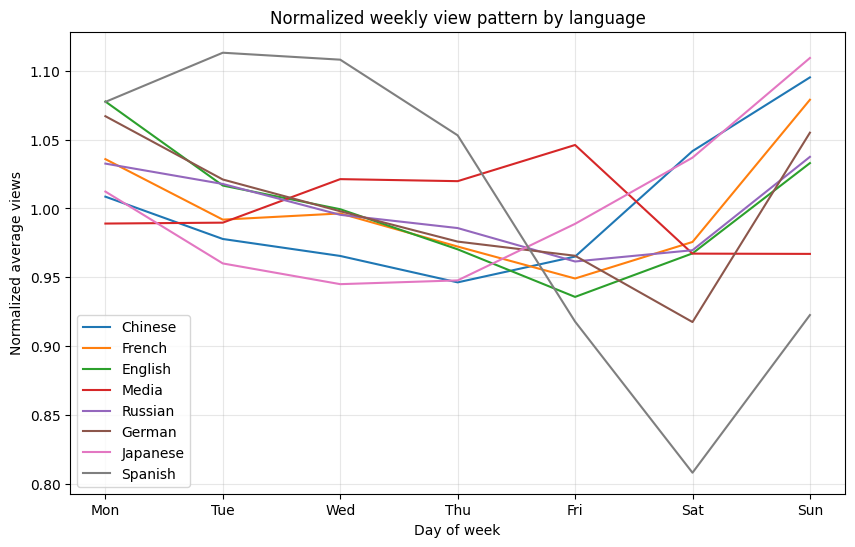

In [25]:
labels={'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
       }

plt.figure(figsize=(10, 6))
for lang, pattern in avg_weekday_pattern_norm.items():
    plt.plot(range(7), pattern.values, label=labels.get(lang, lang))

plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Day of week')
plt.ylabel('Normalized average views')
plt.title('Normalized weekly view pattern by language')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [22]:
avg_weekday_rank = weekday_df.rank(axis=0, ascending=False, method='dense').astype(int)
avg_weekday_rank['avg rank'] = avg_weekday_rank.mean(axis=1).round(2)
print(avg_weekday_rank)

     zh  fr  en  na  ru  de  ja  es  avg rank
Mon   3   2   1   5   2   1   3   3      2.50
Tue   4   4   3   4   3   3   5   1      3.38
Wed   5   3   4   2   4   4   7   2      3.88
Thu   7   6   5   3   5   5   6   4      5.12
Fri   6   7   7   1   7   6   4   6      5.50
Sat   2   5   6   6   6   7   2   7      5.12
Sun   1   1   2   7   1   2   1   5      2.50


In [72]:
en_df = lang_sets['en'].copy()
main_page_mask = en_df['Page'].str.startswith('Main_Page')
special_mask = en_df['Page'].str.startswith('Special:')
error_404_mask = en_df['Page'].str.startswith('404')
user_mask = en_df['Page'].str.startswith('User:')

main_pages = en_df[main_page_mask]
special_pages = en_df[special_mask]
error_404_pages = en_df[error_404_mask]
user_pages = en_df[user_mask]
regular_pages = en_df[~(main_page_mask | special_mask | error_404_mask | user_mask)]

print(f"Main pages: {len(main_pages)} pages")
print(f"Special pages: {len(special_pages)} pages") 
print(f"404 pages: {len(error_404_pages)} pages")
print(f"User pages: {len(user_pages)} pages")
print(f"Regular pages: {len(regular_pages)} pages")

Main pages: 5 pages
Special pages: 84 pages
404 pages: 3 pages
User pages: 32 pages
Regular pages: 23984 pages


In [74]:
prefix_counts = en_df['Page'].str.extract(r'^([^:]*):')[0].value_counts()

print("Prefixes and their counts:")
for prefix, count in prefix_counts.items():
    print(f"{prefix}: {count}")

Prefixes and their counts:
UFC_Fight_Night: 89
Special: 84
User: 32
UFC_on_Fox: 27
Wikipedia: 24
NXT_TakeOver: 23
Star_Wars: 22
File: 21
American_Horror_Story: 17
Captain_America: 12
X-Men: 12
Batman: 11
The_Ultimate_Fighter: 11
Portal: 9
Call_of_Duty: 8
Category: 8
Teenage_Mutant_Ninja_Turtles: 8
The_Divergent_Series: 8
Thor: 8
The_Purge: 8
XXx: 8
Survivor: 8
List_of_Pokémon: 8
Avengers: 8
Help: 6
XXX: 5
Template: 5
Star_Wars_Episode_II: 4
24: 4
Mechanic: 4
Miraculous: 4
Hwarang: 4
The_People_v._O._J._Simpson: 4
Production_of_Avengers: 4
Popstar: 4
Voltron: 4
Ouija: 4
Five_Nights_at_Freddy's: 4
Roadblock: 4
RuPaul's_Drag_Race: 4
Jack_Reacher: 4
TLC: 4
Kahaani_2: 4
Re: 4
Raaz: 4
Gilmore_Girls: 4
Grease: 4
Star_Wars_Episode_III: 4
M.S._Dhoni: 4
Batman_v_Superman: 4
Neighbors_2: 4
List_of_Naruto: 4
Pirates_of_the_Caribbean: 4
Mad_Max: 4
Spider-Man: 4
Transformers: 4
Alien: 4
Kong: 4
13_Hours: 4
Kingsman: 4
The_Hunger_Games: 4
Moon_Lovers: 4
John_Wick: 4
Independence_Day: 4
Guardian: 4
Th

In [71]:
regular_pages.head(30)

Page  2015-07-01  2015-07-02  \
12  Donald_Trump_en.wikipedia.org_all-access_all-a...     82159.0     83458.0   
13    XHamster_en.wikipedia.org_all-access_all-agents      3009.0      3034.0   
14    XHamster_en.wikipedia.org_mobile-web_all-agents      1776.0      1742.0   
19  Donald_Trump_en.wikipedia.org_mobile-web_all-a...     44981.0     44451.0   
20  Web_scraping_en.wikipedia.org_all-access_all-a...       874.0       968.0   
21   Web_scraping_en.wikipedia.org_desktop_all-agents       774.0       829.0   
24  User:GoogleAnalitycsRoman/google-api_en.wikipe...    258566.0    228871.0   
25   Donald_Trump_en.wikipedia.org_desktop_all-agents     35886.0     37554.0   
26       AMGTV_en.wikipedia.org_all-access_all-agents        44.0        62.0   
27  Proyecto_40_en.wikipedia.org_all-access_all-ag...      1157.0      1234.0   
28    Proyecto_40_en.wikipedia.org_desktop_all-agents      1106.0      1131.0   
34          AMGTV_en.wikipedia.org_desktop_all-agents        40.0        55.0   
35      Google_en.wikipedia.org_all-access_all-agents     48736.0     47986.0   
37  Deaths_in_2016_en.wikipedia.org_all-access_all...         0.0         0.0   
38  Star_Wars:_The_Force_Awakens_en.wikipedia.org_...     13400.0     13169.0   
39  United_States_en.wikipedia.org_all-access_all-...     47382.0     46071.0   
40  Lali_Espósito_en.wikipedia.org_all-access_all-...       196.0       164.0   
41  Pablo_Escobar_en.wikipedia.org_all-access_all-...     10189.0     18100.0   
42  Dulce_María_en.wikipedia.org_all-access_all-ag...       396.0       406.0   
43         XXX_en.wikipedia.org_all-access_all-agents     16482.0     15777.0   
44    Dulce_María_en.wikipedia.org_desktop_all-agents       149.0       138.0   
45    Facebook_en.wikipedia.org_all-access_all-agents     51099.0     99466.0   
46  Elizabeth_II_en.wikipedia.org_all-access_all-a...     17833.0     16688.0   
47  Portal:Current_events_en.wikipedia.org_all-acc...     46129.0     49704.0   
48  Barack_Obama_en.wikipedia.org_all-access_all-a...     28422.0     26087.0   
49  Melania_Trump_en.wikipedia.org_all-access_all-...     16143.0     16625.0   
50  Lali_Espósito_en.wikipedia.org_desktop_all-agents       115.0        93.0   
51  Game_of_Thrones_en.wikipedia.org_all-access_al...     42619.0     40759.0   
52         XXX_en.wikipedia.org_mobile-web_all-agents     14073.0     13497.0   
53  United_States_presidential_election,_2016_en.w...     20280.0     22827.0   

    2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
12     55615.0     43865.0     42220.0     38412.0     44158.0     48631.0   
13      2799.0      2560.0      2897.0      2879.0      3214.0      3434.0   
14      1751.0      1549.0      1709.0      1718.0      2017.0      2235.0   
19     32464.0     26430.0     25243.0     18808.0     21612.0     24113.0   
20       781.0       477.0       587.0      1132.0       991.0       991.0   
21       658.0       376.0       480.0      1002.0       892.0       869.0   
24    236295.0     89391.0     57027.0    246659.0    237978.0    235122.0   
25     22154.0     16640.0     16158.0     18986.0     21857.0     23773.0   
26        48.0        57.0        46.0        71.0        99.0        51.0   
27      1559.0      1943.0      1433.0      1275.0      1160.0      1259.0   
28      1508.0      1852.0      1367.0      1231.0      1112.0      1230.0   
34        42.0        40.0        29.0        62.0        94.0        44.0   
35     45212.0     40972.0     42400.0     46712.0     47963.0     45813.0   
37         0.0         0.0         0.0         0.0         0.0         0.0   
38     13028.0     13653.0     15315.0     16921.0     16431.0     21649.0   
39     44393.0     57864.0     54605.0     54012.0     48566.0     45295.0   
40       166.0       223.0       167.0       185.0       184.0       157.0   
41     12530.0     14181.0     11809.0     11696.0     11274.0     10650.0   
42       329.0       323.0       288.0       381.0     

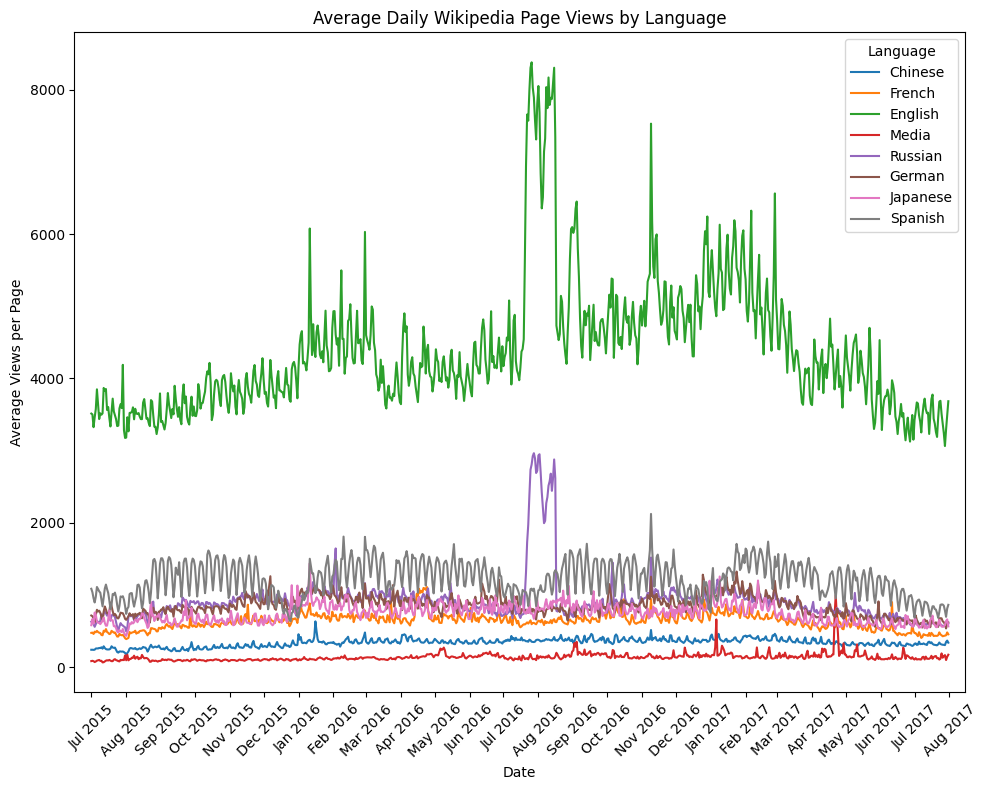

In [10]:
fig = plt.figure(figsize=[10,8])
plt.ylabel('Average Views per Page')
plt.xlabel('Date')
plt.title('Average Daily Wikipedia Page Views by Language')
labels={'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
       }

for lang, series in avg_views_by_lang.items():
    plt.plot(train_dates, series.values, label=labels.get(lang, lang))

plt.legend(title='Language')

ax = plt.gca()

# Ticks at start of month
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)

delta = timedelta(days=15)
ax.set_xlim([train_dates.min() - delta, train_dates.max() + delta])

plt.tight_layout()
plt.show()

In [8]:
for lang, series in avg_views_by_lang.items():
    avg_views_by_lang[lang].index = pd.to_datetime(series.index)

In [9]:
for lang, series in avg_views_by_lang_test.items():
    avg_views_by_lang_test[lang].index = pd.to_datetime(series.index)

In [17]:
def plot_and_save_lang(lang):
    """
    Plot average daily wikipedia page views for a given language and save the image to plots folder
    
    Parameters:
    lang (string): Language code
    """
    
    plt.figure(figsize=(10, 4))

    plt.ylabel('Average Views per Page')
    plt.xlabel('Date')
    plt.title(labels.get(lang, lang) + ' Wikipedia Subset: Average Daily Page Views')

    
    plt.plot(avg_views_by_lang[lang].index, avg_views_by_lang[lang].values)
   
    ax = plt.gca()

    # Ticks at start of month
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))


    plt.xticks(rotation=45)

    delta = timedelta(days=15)
    ax.set_xlim([train_dates.min() - delta, train_dates.max() + delta])

    plt.tight_layout()

    
    # Save the plot
    filename = f'plots/plot_{lang}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()



In [58]:
def plot_lang_with_highlight_lines(lang, summary_weekday_rank, labels=None):
    """
    Plot average daily Wikipedia page views for a language, highlighting
    the most popular and least popular weekdays.

    Parameters
    ----------
    lang : str
        Language code
    summary_weekday_rank : pd.DataFrame
        DataFrame with weekday ranks, index=weekdays, columns=languages, includes 'Average Rank'
    labels : dict, optional
        Mapping from language code to full language name
    """
    
    # --- Identify most and least popular weekdays for this language
    # weekday names are index: 'Mon', 'Tue', ... or adjust accordingly
    weekday_ranks = summary_weekday_rank[lang]
    most_popular_day = weekday_ranks.idxmin()  # rank 1 = most active
    least_popular_day = weekday_ranks.idxmax() # rank max = least active
    
    # --- Map weekday names to weekday numbers (0=Mon,...6=Sun)
    weekday_map = {'Mon':0, 'Tue':1, 'Wed':2, 'Thu':3, 'Fri':4, 'Sat':5, 'Sun':6}
    most_day_num = weekday_map[most_popular_day]
    least_day_num = weekday_map[least_popular_day]
    
    # --- Extract the series for the language
    series = avg_views_by_lang[lang]
    dates = pd.to_datetime(series.index)

    # Select only the days matching the most/least popular weekday
    most_day_series = series[dates.weekday == most_day_num]
    least_day_series = series[dates.weekday == least_day_num]
    
    # --- Plotting
    plt.figure(figsize=(12, 5))
    
    # Average daily views
    plt.plot(avg_views_by_lang[lang].index, avg_views_by_lang[lang].values, label='Average daily views', linewidth=1.5)
    
    # Most popular weekday
    plt.plot(most_day_series.index, most_day_series.values, label=f'Most popular weekday: {most_popular_day}', color='orange', linestyle='--', linewidth=1.5)
    
    # Least popular weekday
    plt.plot(least_day_series.index, least_day_series.values, label=f'Least popular weekday: {least_popular_day}', color='red', linestyle='--', linewidth=1.5)
    
    # Labels, title
    plt.xlabel('Date')
    plt.ylabel('Average Views per Page')
    plt.title(f"{labels.get(lang, lang) if labels else lang} Wikipedia: Daily views with most/least popular weekdays highlighted")
    plt.legend()
    
    # Format x-axis
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45)
    
    delta = timedelta(days=15)
    plt.xlim([avg_views_by_lang[lang].index.min() - delta, avg_views_by_lang[lang].index.max() + delta])
    
    plt.tight_layout()
    plt.show()

In [60]:
def plot_and_save_lang_with_highlights(lang, summary_weekday_rank, labels=None):
    """
    Plot average daily Wikipedia page views for a language, highlighting
    the most popular and least popular weekdays as scatter points.

    Parameters
    ----------
    lang : str
        Language code
    summary_weekday_rank : pd.DataFrame
        DataFrame with weekday ranks (index=weekdays, columns=languages)
    labels : dict, optional
        Mapping from language code to full language name
    """

    # --- Identify most and least popular weekdays
    weekday_ranks = summary_weekday_rank[lang]
    most_popular_day = weekday_ranks.idxmin()
    least_popular_day = weekday_ranks.idxmax()

    # Map weekday names to weekday numbers
    weekday_map = {'Mon':0, 'Tue':1, 'Wed':2, 'Thu':3, 'Fri':4, 'Sat':5, 'Sun':6}
    most_day_num = weekday_map[most_popular_day]
    least_day_num = weekday_map[least_popular_day]

    # --- Extract series
    series = avg_views_by_lang[lang]
    dates = pd.to_datetime(series.index)

    # Select days matching most/least popular weekdays
    most_day_series = series[dates.weekday == most_day_num]
    least_day_series = series[dates.weekday == least_day_num]

    # --- Plotting
    plt.figure(figsize=(12, 5))

    # Average daily views as line
    plt.plot(series.index, series.values, label='Average daily views', linewidth=1.5)

    # Scatter points for most popular weekday
    plt.scatter(most_day_series.index, most_day_series.values,
                label=f'Most popular weekday: {most_popular_day}',
                color='orange', marker='o', s=5, zorder=5)

    # Scatter points for least popular weekday
    plt.scatter(least_day_series.index, least_day_series.values,
                label=f'Least popular weekday: {least_popular_day}',
                color='red', marker='o', s=5, zorder=5)

    # Labels and title
    plt.xlabel('Date')
    plt.ylabel('Average Views per Page')
    plt.title(f"{labels.get(lang, lang) if labels else lang} Wikipedia Subset: Daily Views with Weekday Highlights")
    plt.legend()

    # Format x-axis
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45)

    delta = timedelta(days=15)
    plt.xlim([series.index.min() - delta, series.index.max() + delta])

    plt.tight_layout()

    # Save the plot
    filename = f'plots/plot_highlight_{lang}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')


    plt.show()

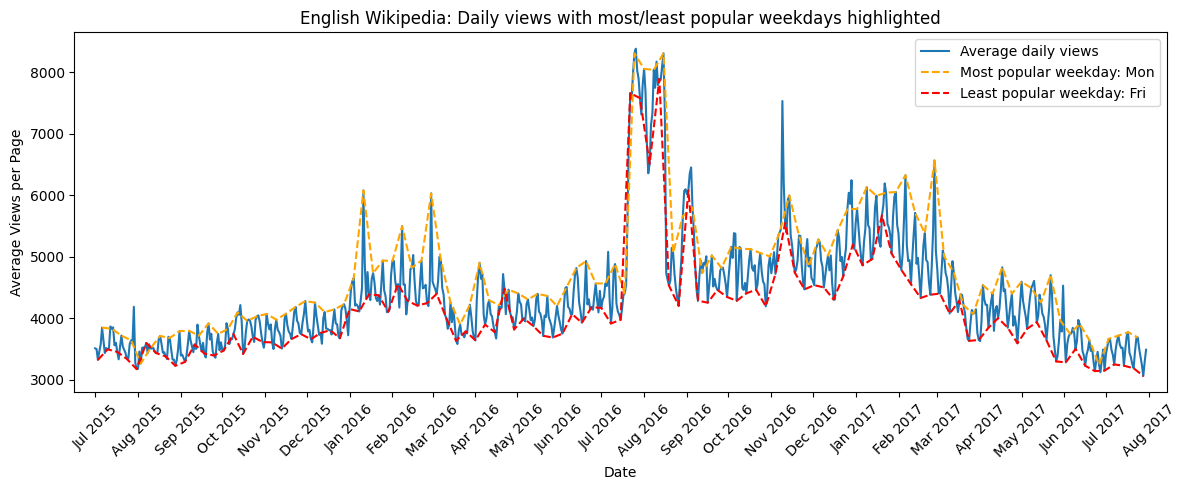

In [62]:
plot_lang_with_highlight_lines('en', avg_weekday_rank, labels)

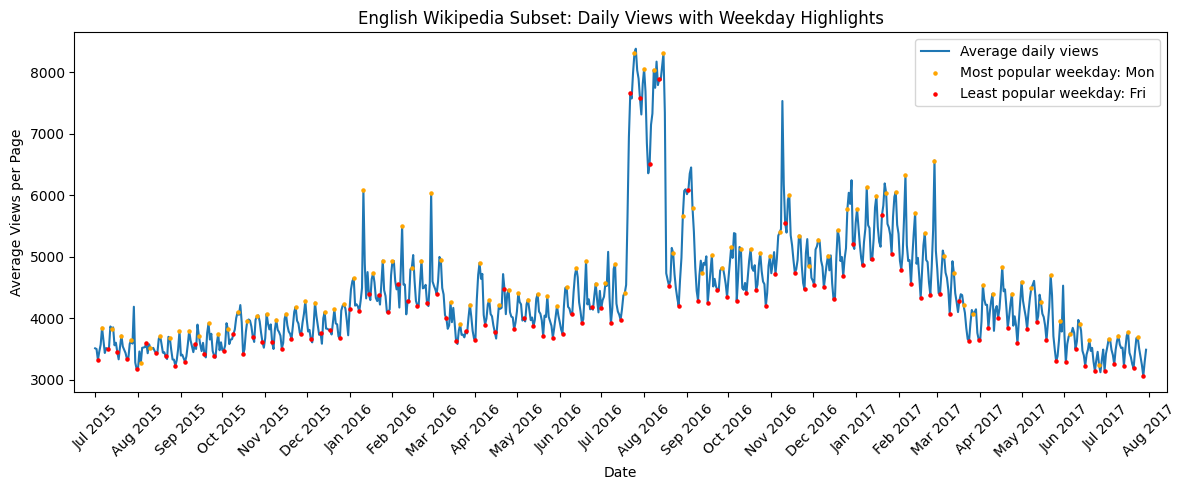

In [61]:
plot_and_save_lang_with_highlights('en', avg_weekday_rank, labels)

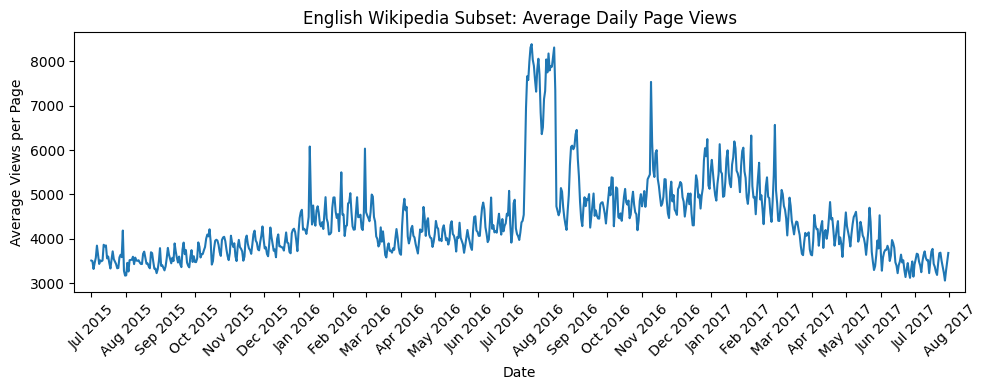

In [18]:
plot_and_save_lang('en')

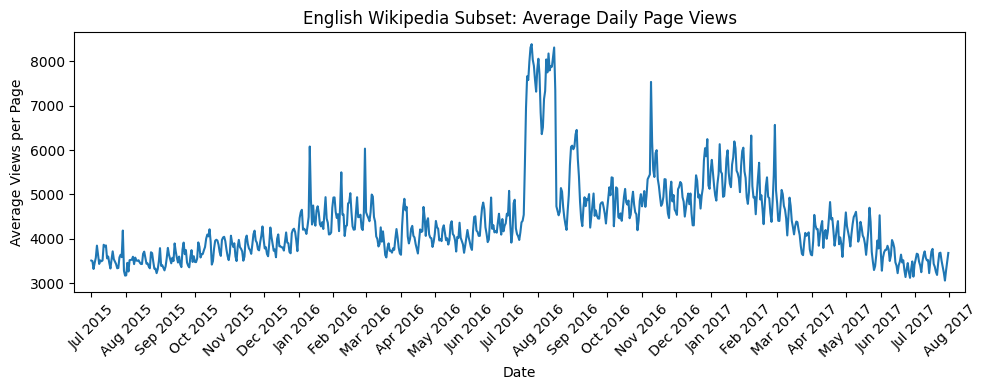

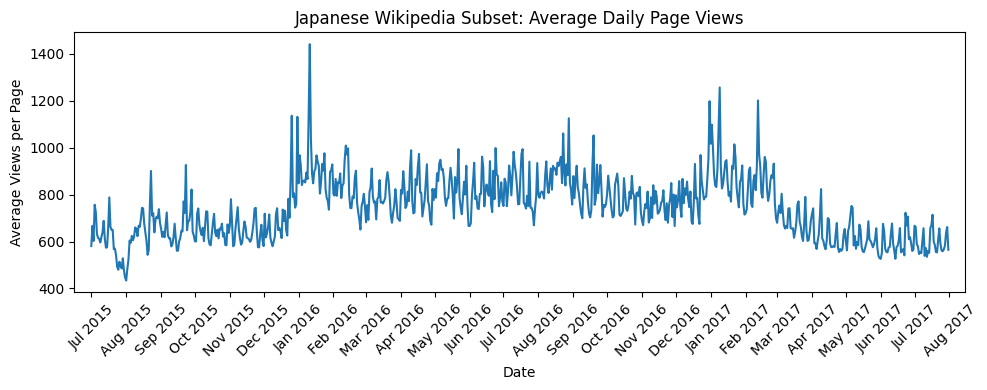

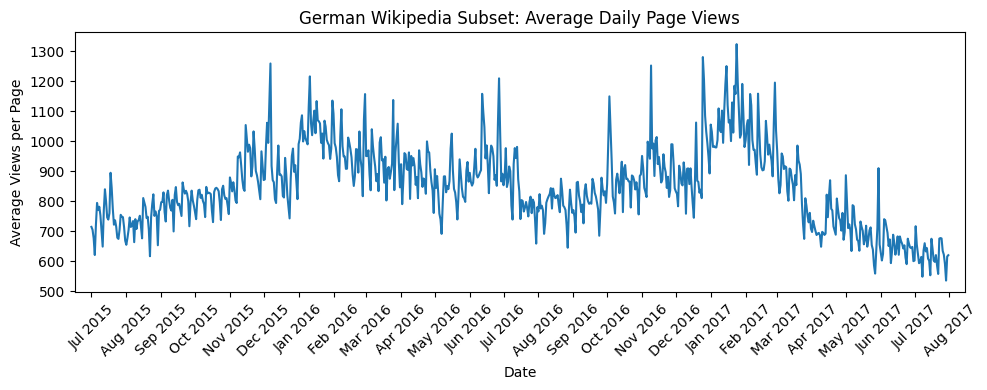

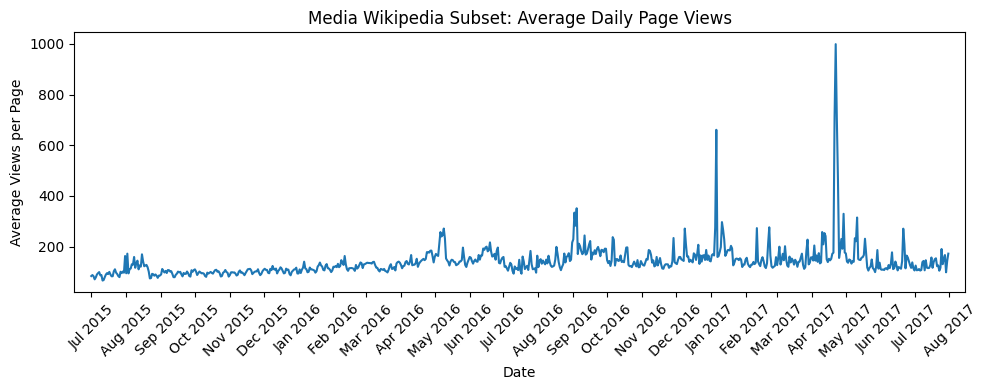

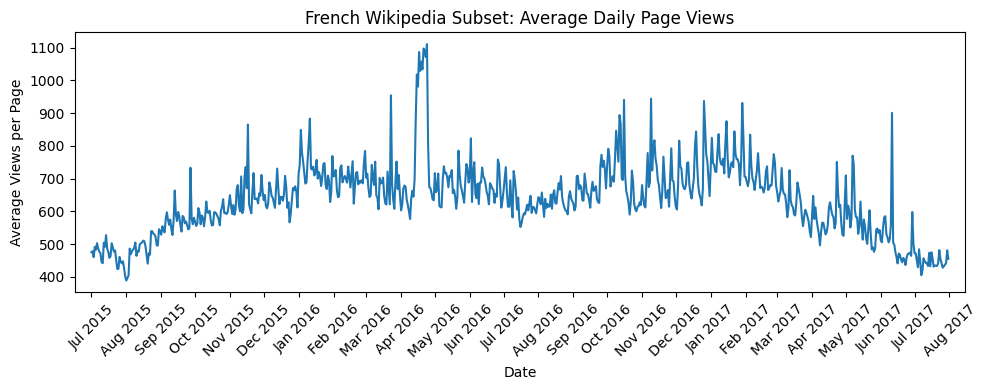

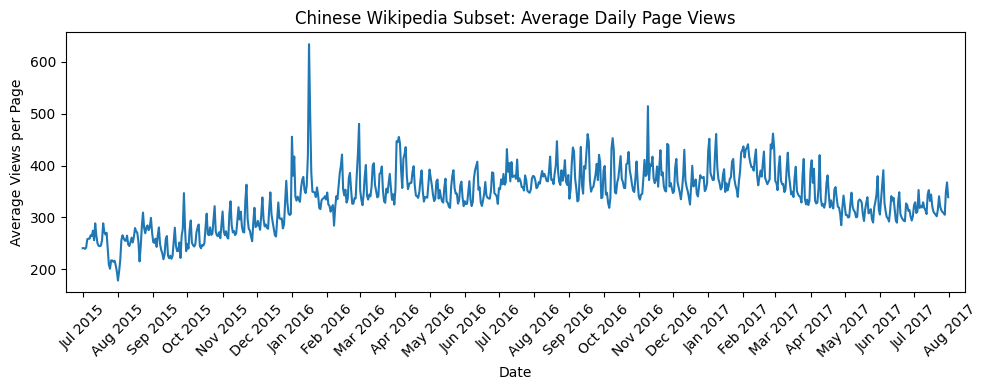

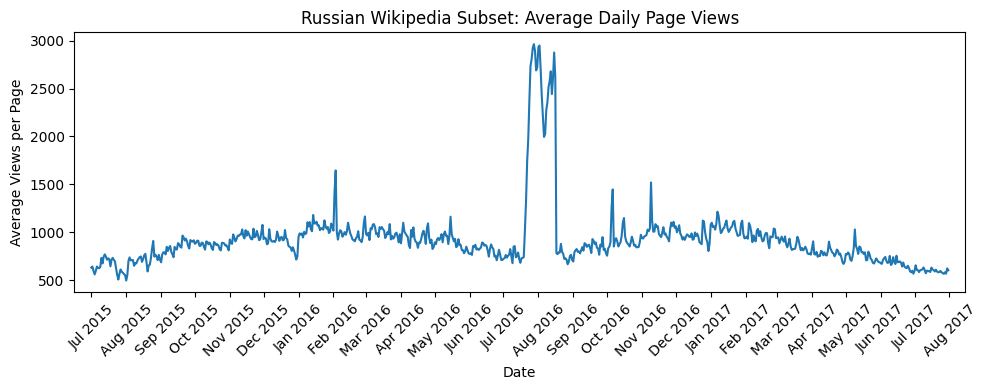

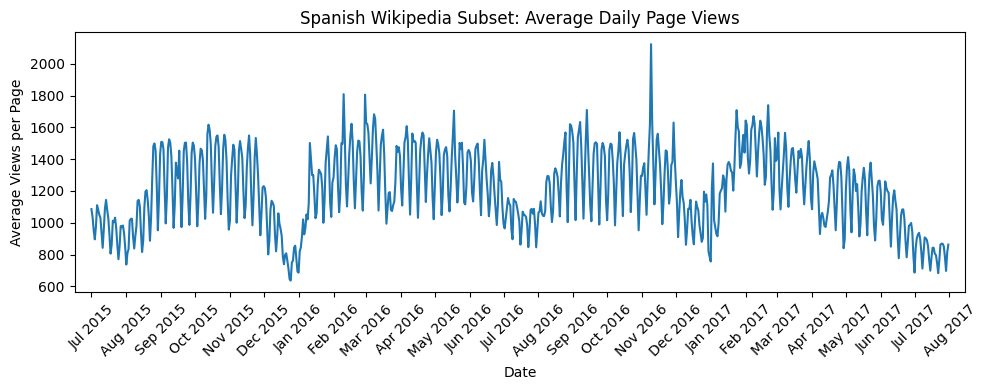

In [19]:
for lang in labels.keys():
    plot_and_save_lang(lang)

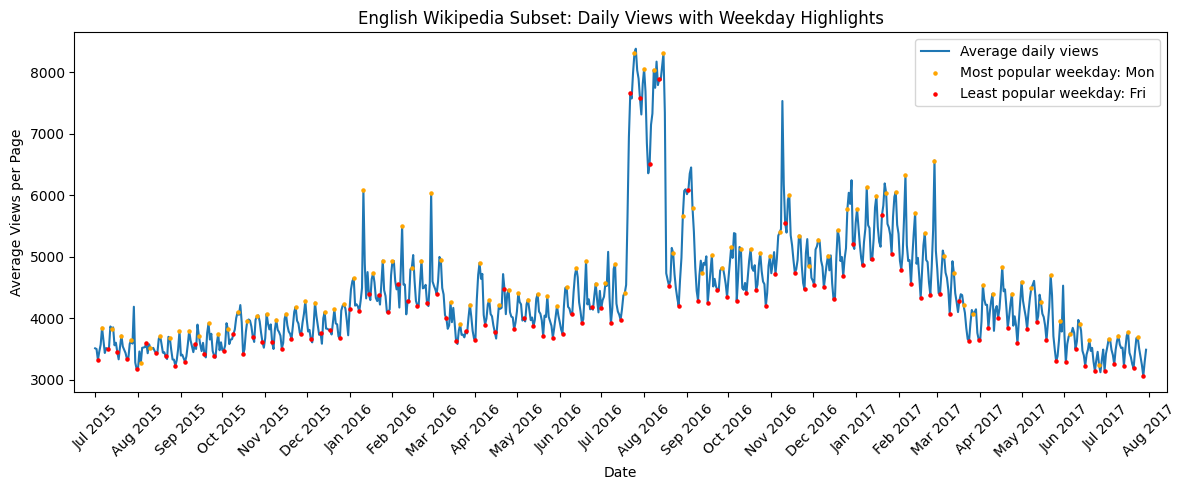

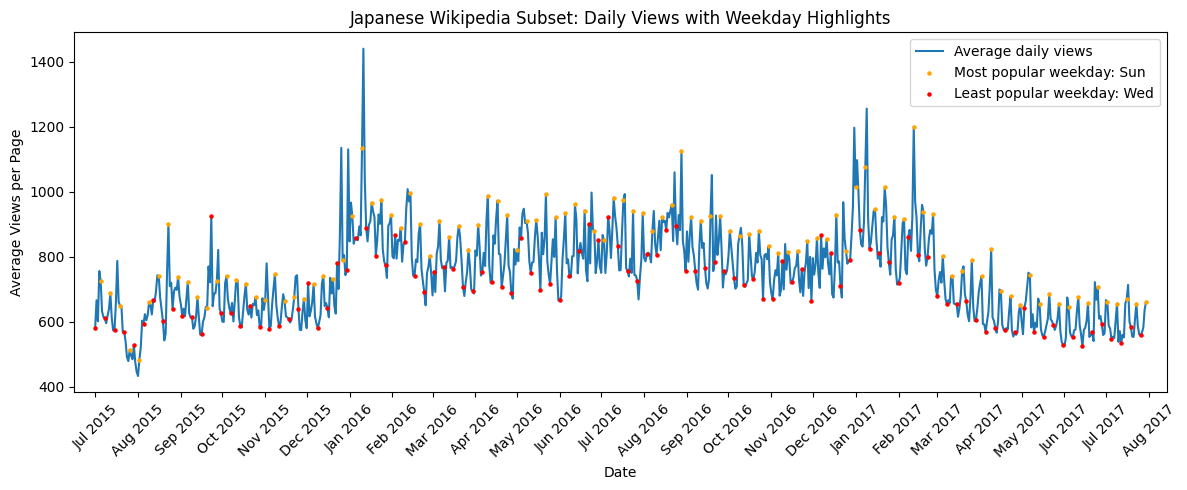

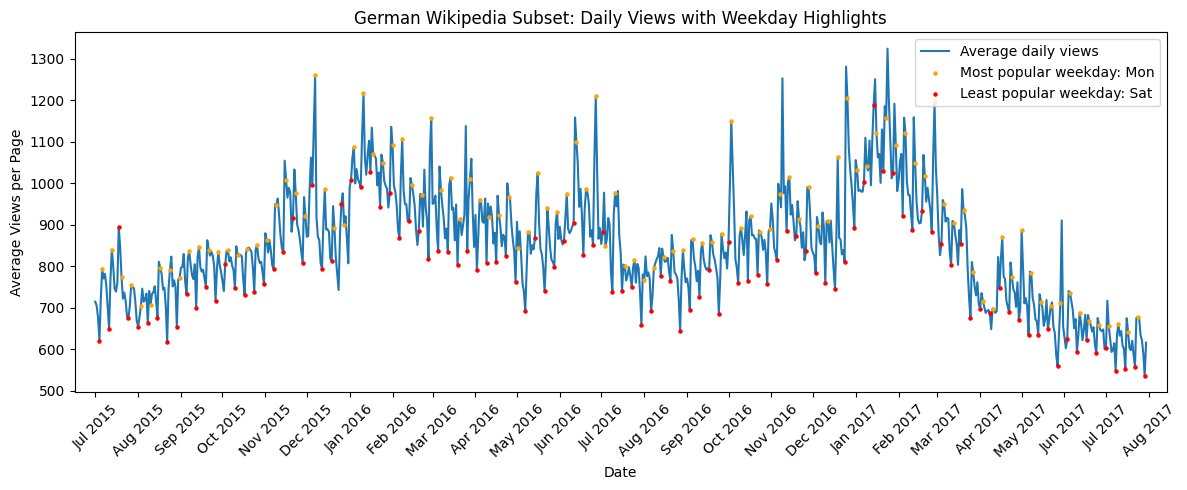

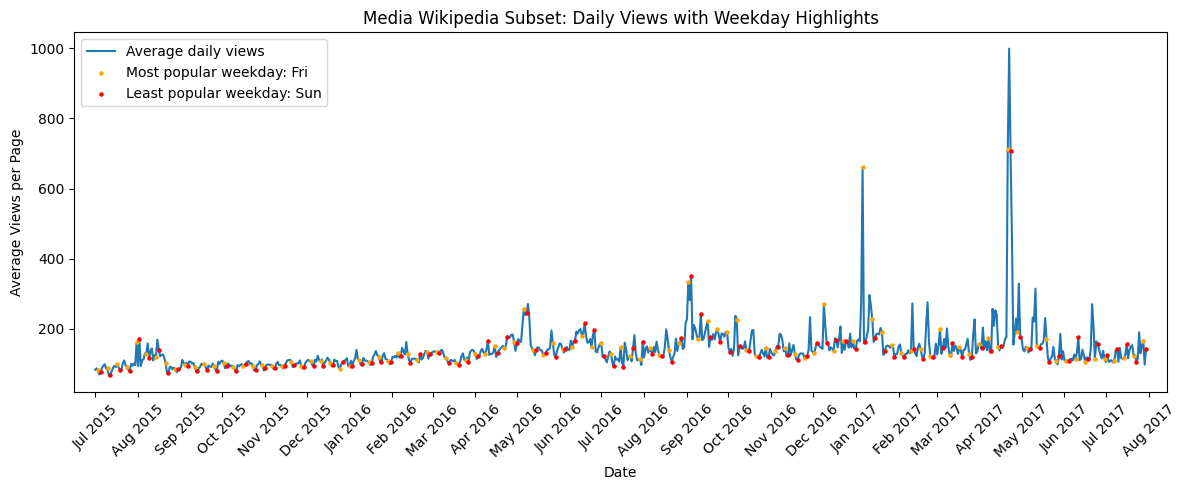

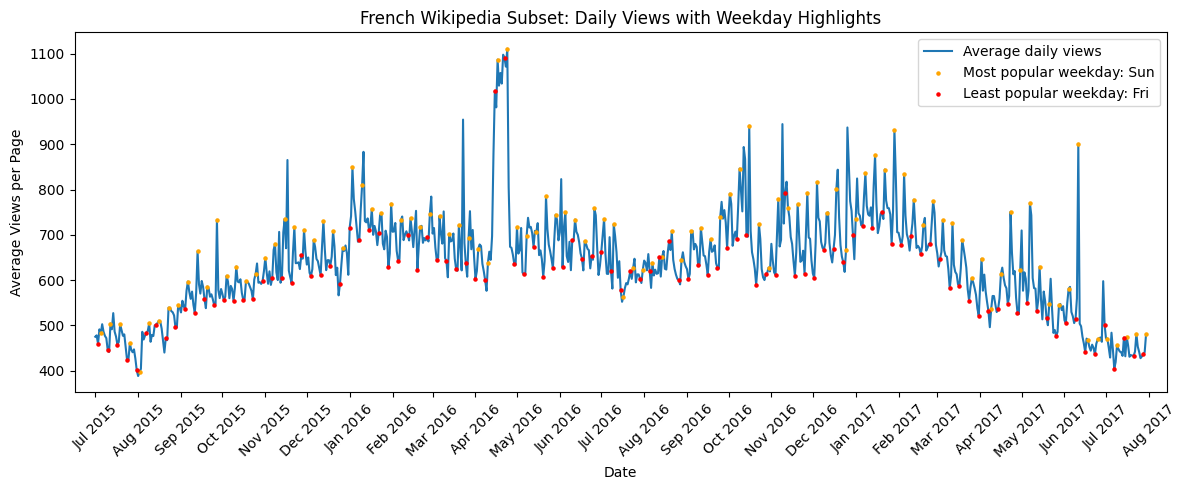

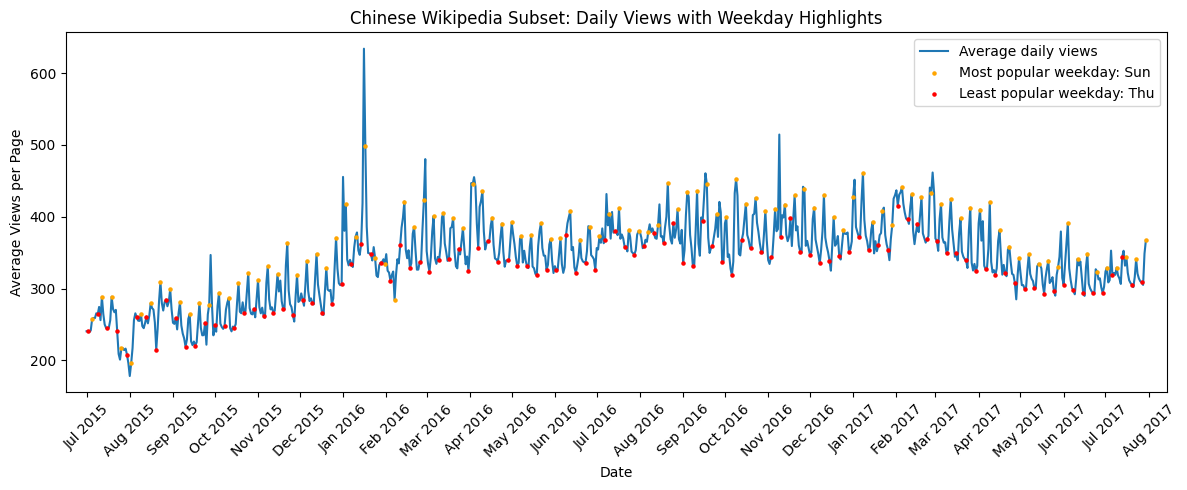

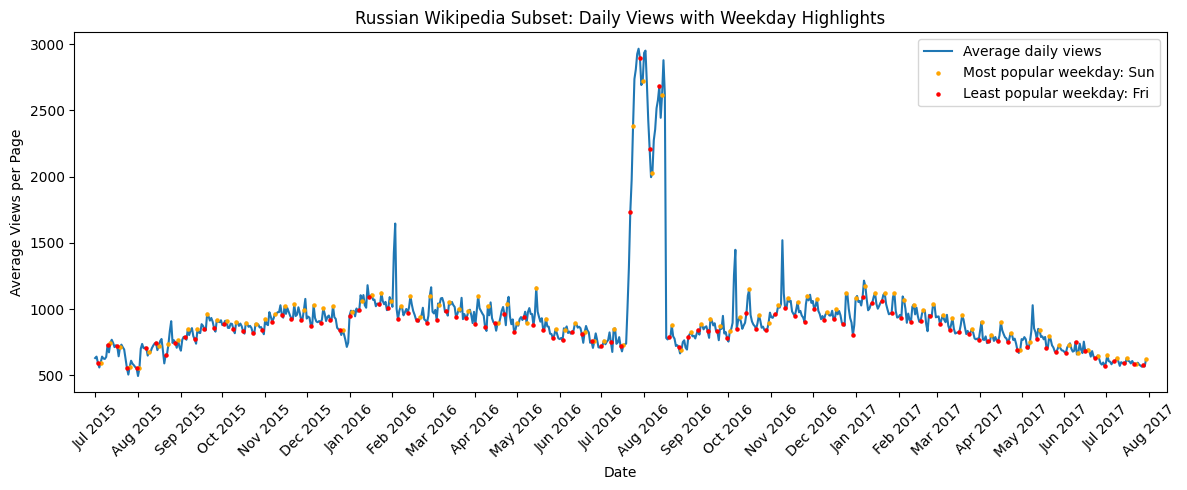

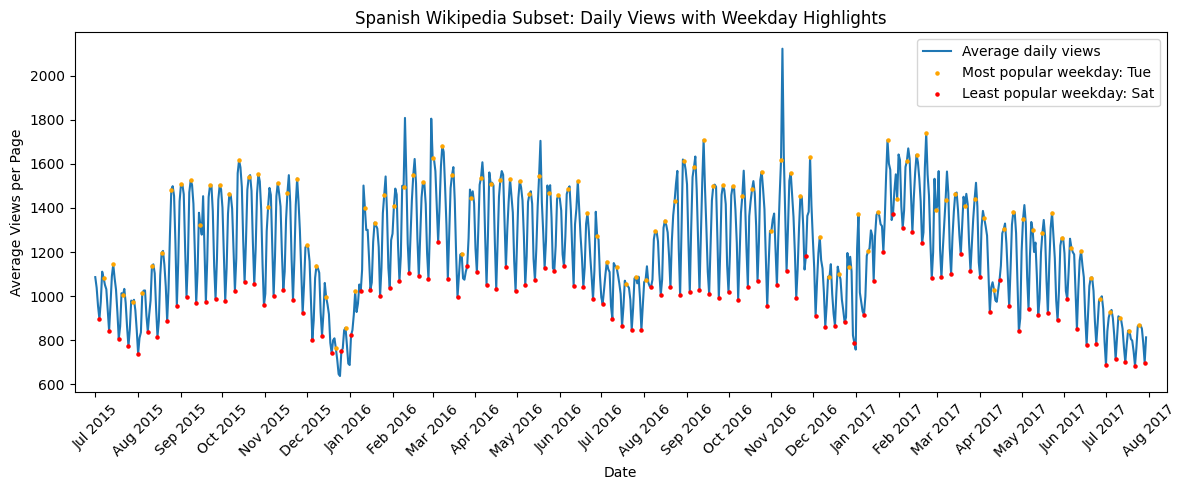

In [64]:
for lang in labels.keys():
    plot_and_save_lang_with_highlights(lang, avg_weekday_rank, labels)

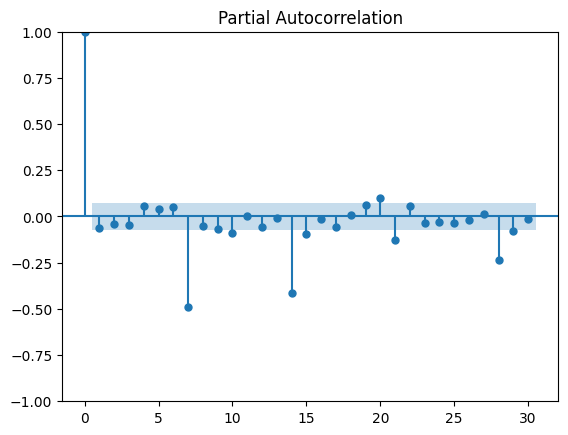

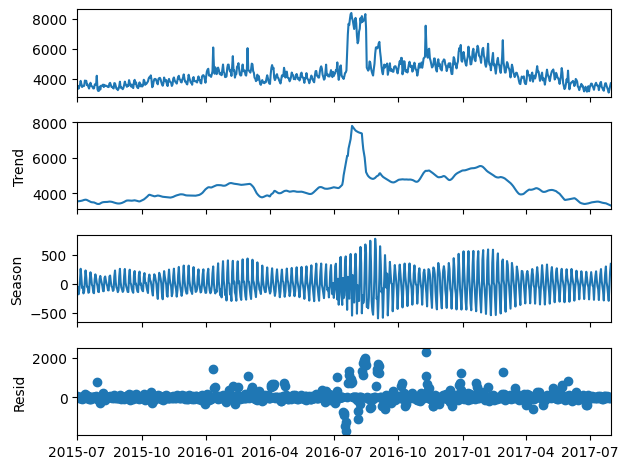

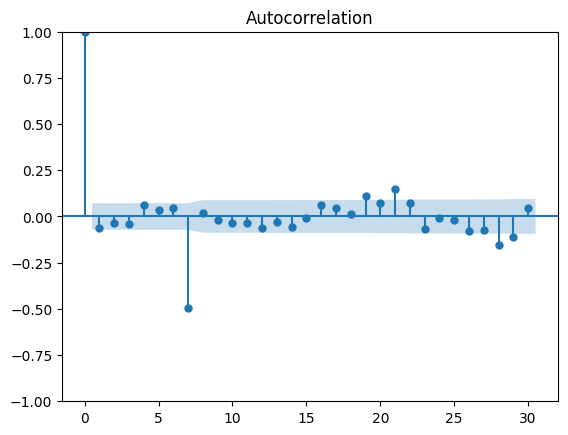

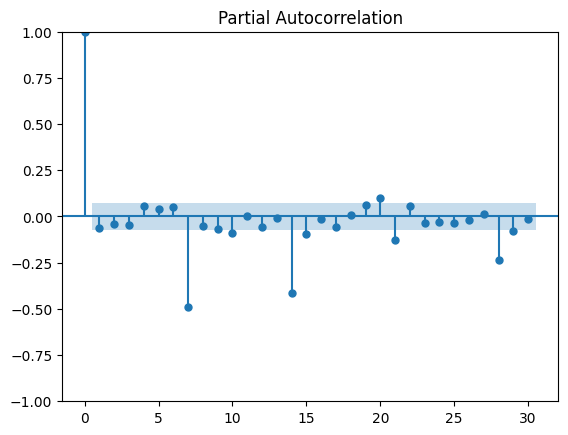

In [22]:
series = avg_views_by_lang["en"]
series_test = avg_views_by_lang_test["en"]

stl = STL(series, period=7, robust=True)
res = stl.fit()
res.plot()

series_diff1 = series.diff(periods=1)
series_diff1_7 = series_diff1.diff(periods=7)



plot_acf(series_diff1_7.dropna(), lags=30)
plot_pacf(series_diff1_7.dropna(), lags=30)

d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


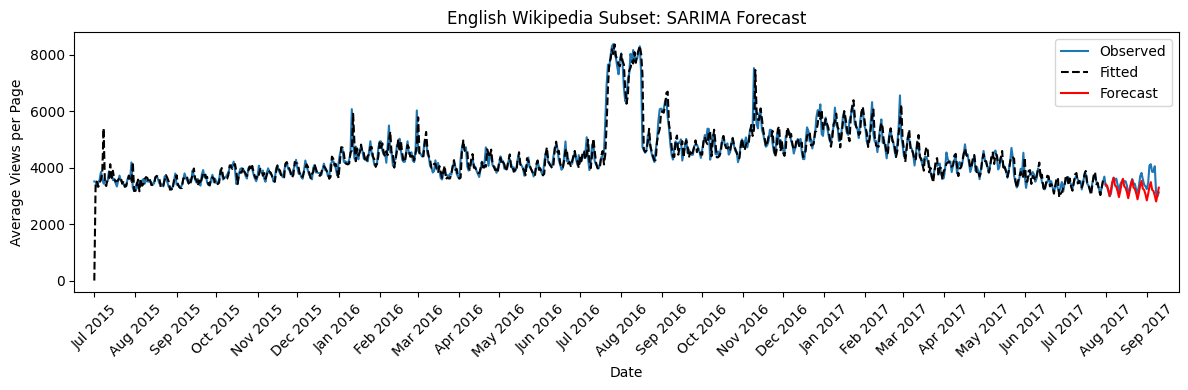

In [24]:
# Fit SARIMA model
model = SARIMAX(series, order=(1,1,1), seasonal_order=(2,1,1,7))
fit = model.fit()

# Forecast next 30 days
forecast = fit.forecast(steps=41)
fitted_values = fit.fittedvalues

series_combined = pd.concat([series, series_test])

# Plot forecast vs. history
plt.figure(figsize=(12,4))
plt.plot(series_combined.index, series_combined, label="Observed", color='C0')
plt.plot(series.index, fitted_values, label="Fitted", color="black", linestyle="--")
plt.plot(forecast.index, forecast, label="Forecast", color="red")
plt.legend()
plt.ylabel('Average Views per Page')
plt.xlabel('Date')
plt.title('English Wikipedia Subset: SARIMA Forecast')

ax = plt.gca()

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)

delta = timedelta(days=15)
ax.set_xlim([train_dates.min() - delta, forecast.index.max() + delta])


plt.tight_layout()
plt.show()



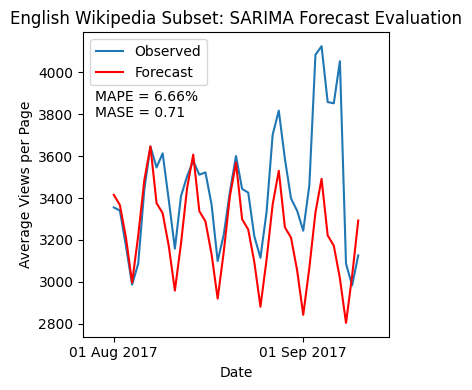

In [58]:
mape = np.mean(np.abs((series_test - forecast) / series_test)) * 100
mase = np.mean(np.abs(series_test - forecast))/np.mean(np.abs(series.values[7:] - series.values[:-7]))


plt.figure(figsize=(4,4))
plt.plot(series_test.index, series_test, label="Observed")
plt.plot(forecast.index, forecast, label=f"Forecast", color="red")
plt.legend()
plt.title('English Wikipedia Subset: SARIMA Forecast Evaluation')
plt.ylabel('Average Views per Page')
plt.xlabel('Date')


ax = plt.gca()

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))  # show day + month + year

#plt.xticks(rotation=45)

delta = timedelta(days=5)
ax.set_xlim([series_test.index.min() - delta, series_test.index.max() + delta])

plt.text(
    0.04, 0.81,                     # position in axes coordinates (left, top)
    f"MAPE = {mape:.2f}%\nMASE = {mase:.2f}",          # text
    transform=ax.transAxes,          # use axes coordinates
    verticalalignment='top'
)


plt.tight_layout()
plt.show()


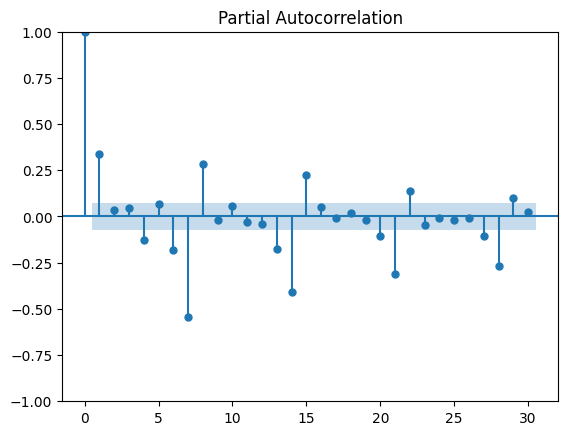

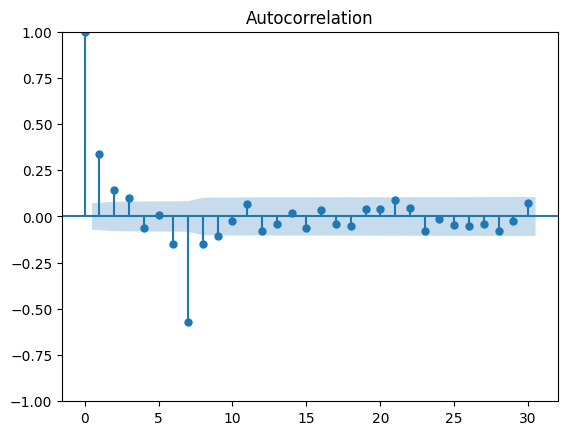

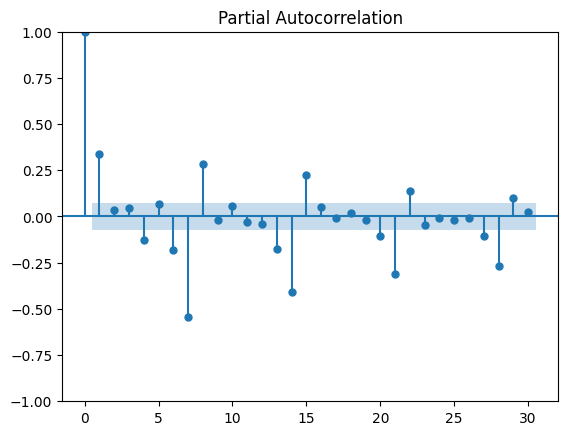

In [ ]:
series = avg_views_by_lang["ja"]
series_test = avg_views_by_lang_test["ja"]

# plot_acf(series.dropna(), lags=30)
# plot_pacf(series.dropna(), lags=30)

series_diff7 = series.diff(periods=7)

series_diff7_7 = series_diff7.diff(periods=7)


# plot_acf(series_diff7.dropna(), lags=30)
# plot_pacf(series_diff7.dropna(), lags=30)

plot_acf(series_diff7_7.dropna(), lags=30)
plot_pacf(series_diff7_7.dropna(), lags=30)



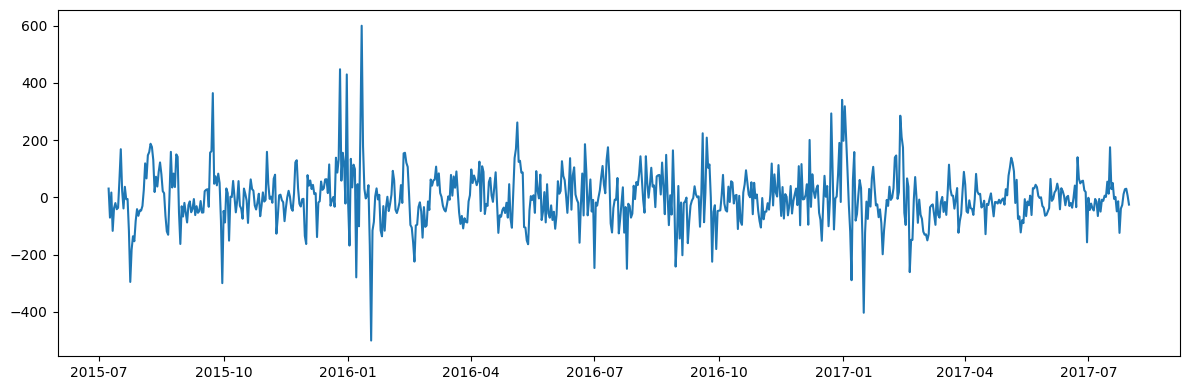

In [29]:
plt.figure(figsize=(12,4))
plt.plot(series_diff7.index, series_diff7)
plt.tight_layout()
plt.show()

d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


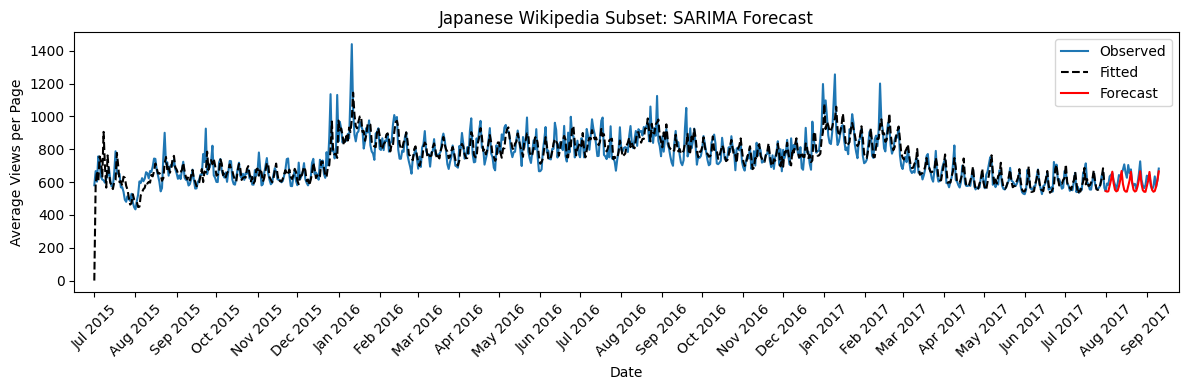

In [10]:
#Japanese Subset

series = avg_views_by_lang["ja"]
series_test = avg_views_by_lang_test["ja"]

# Fit SARIMA model
model = SARIMAX(series, order=(1,1,1), seasonal_order=(2,1,2,7))
fit = model.fit()

# Forecast next 41 days
forecast = fit.forecast(steps=41)
fitted_values = fit.fittedvalues

series_combined = pd.concat([series, series_test])

# Plot forecast vs. history
plt.figure(figsize=(12,4))
plt.plot(series_combined.index, series_combined, label="Observed")
plt.plot(series.index, fitted_values, label="Fitted", color="black", linestyle="--")
plt.plot(forecast.index, forecast, label="Forecast", color="red")
plt.legend()
plt.ylabel('Average Views per Page')
plt.xlabel('Date')
plt.title('Japanese Wikipedia Subset: SARIMA Forecast')

ax = plt.gca()

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)

delta = timedelta(days=15)
ax.set_xlim([train_dates.min() - delta, forecast.index.max() + delta])


plt.tight_layout()
plt.show()

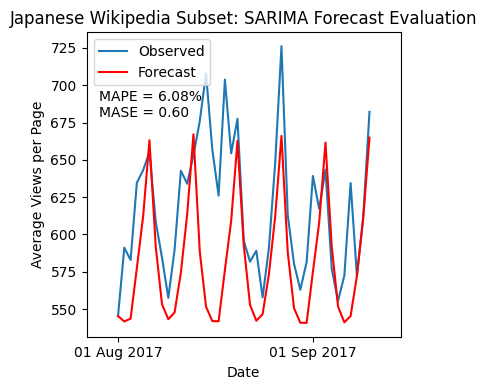

In [63]:
mape = np.mean(np.abs((series_test - forecast) / series_test)) * 100
mase = np.mean(np.abs(series_test - forecast))/np.mean(np.abs(series.values[7:] - series.values[:-7]))

plt.figure(figsize=(4,4))
plt.plot(series_test.index, series_test, label="Observed")
plt.plot(forecast.index, forecast, label=f"Forecast", color="red")
plt.legend(loc="upper left")
plt.title('Japanese Wikipedia Subset: SARIMA Forecast Evaluation')
plt.ylabel('Average Views per Page')
plt.xlabel('Date')


ax = plt.gca()

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))  # show day + month + year

#plt.xticks(rotation=45)

delta = timedelta(days=5)
ax.set_xlim([series_test.index.min() - delta, series_test.index.max() + delta])

plt.text(
    0.04, 0.81,                     # position in axes coordinates (left, top)
    f"MAPE = {mape:.2f}%\nMASE = {mase:.2f}",          # text
    transform=ax.transAxes,          # use axes coordinates
    verticalalignment='top'
)


plt.tight_layout()
plt.show()

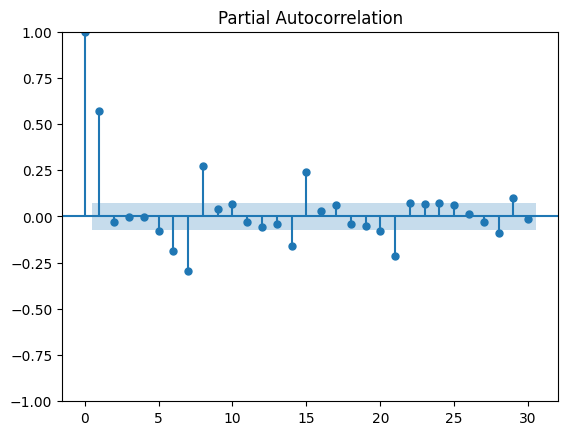

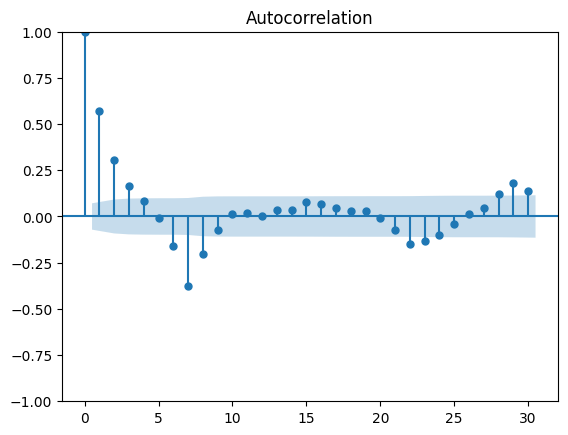

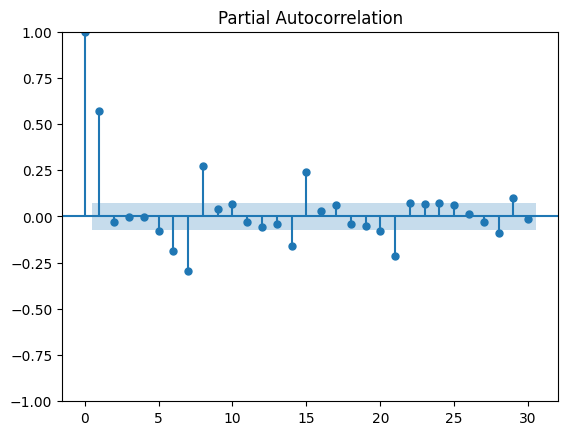

In [64]:
series = avg_views_by_lang["de"]
series_test = avg_views_by_lang_test["de"]
# plot_acf(series.dropna(), lags=30)
# plot_pacf(series.dropna(), lags=30)

series_diff7 = series.diff(periods=7)

series_diff7_7 = series_diff7.diff(periods=7)


plot_acf(series_diff7.dropna(), lags=30)
plot_pacf(series_diff7.dropna(), lags=30)

# plot_acf(series_diff7_7.dropna(), lags=30)
# plot_pacf(series_diff7_7.dropna(), lags=30)


# series_diff1 = series.diff(periods=1)
# series_diff1_7 = series_diff1.diff(periods=7)



# plot_acf(series_diff1_7.dropna(), lags=30)
# plot_pacf(series_diff1_7.dropna(), lags=30)

d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


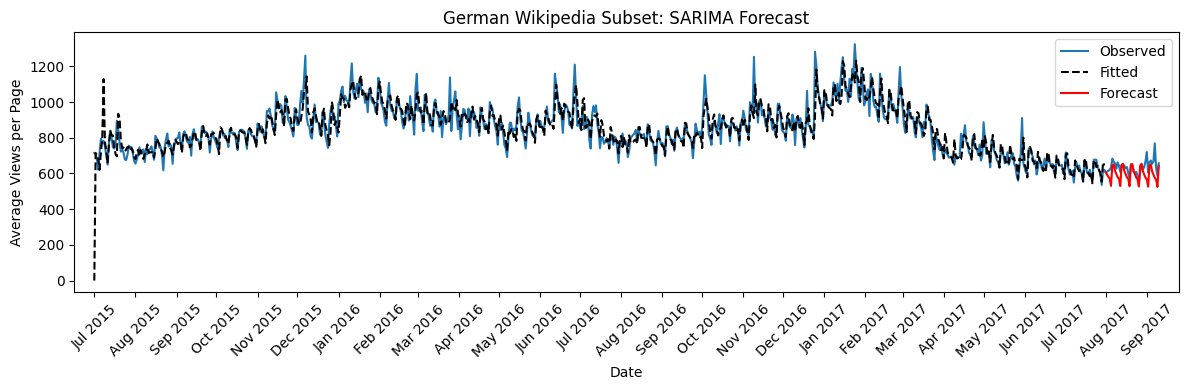

In [18]:
#German Subset

series = avg_views_by_lang["de"]
series_test = avg_views_by_lang_test["de"]

# Fit SARIMA model
model = SARIMAX(series, order=(1,1,1), seasonal_order=(1,1,1,7))
fit = model.fit()
fitted_values = fit.fittedvalues

# Forecast next 41 days
forecast = fit.forecast(steps=41)

series_combined = pd.concat([series, series_test])

# Plot forecast vs. history
plt.figure(figsize=(12,4))
plt.plot(series_combined.index, series_combined, label="Observed")
plt.plot(series.index, fitted_values, label="Fitted", color="black", linestyle="--")
plt.plot(forecast.index, forecast, label="Forecast", color="red")
plt.legend()
plt.ylabel('Average Views per Page')
plt.xlabel('Date')
plt.title('German Wikipedia Subset: SARIMA Forecast')

ax = plt.gca()

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)

delta = timedelta(days=15)
ax.set_xlim([train_dates.min() - delta, forecast.index.max() + delta])


plt.tight_layout()
plt.show()


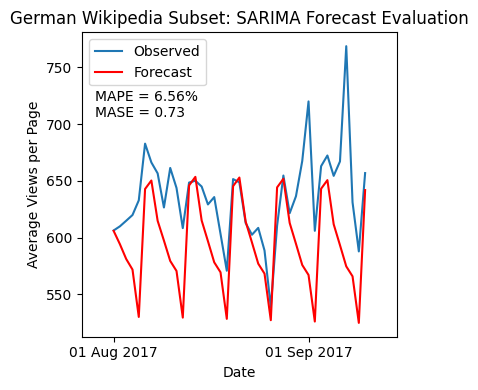

In [66]:
mape = np.mean(np.abs((series_test - forecast) / series_test)) * 100
mase = np.mean(np.abs(series_test - forecast))/np.mean(np.abs(series.values[7:] - series.values[:-7]))

plt.figure(figsize=(4,4))
plt.plot(series_test.index, series_test, label="Observed")
plt.plot(forecast.index, forecast, label=f"Forecast", color="red")
plt.legend(loc="upper left")
plt.title('German Wikipedia Subset: SARIMA Forecast Evaluation')
plt.ylabel('Average Views per Page')
plt.xlabel('Date')


ax = plt.gca()

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))  # show day + month + year

#plt.xticks(rotation=45)

delta = timedelta(days=5)
ax.set_xlim([series_test.index.min() - delta, series_test.index.max() + delta])

plt.text(
    0.04, 0.81,                     # position in axes coordinates (left, top)
    f"MAPE = {mape:.2f}%\nMASE = {mase:.2f}",          # text
    transform=ax.transAxes,          # use axes coordinates
    verticalalignment='top'
)


plt.tight_layout()
plt.show()

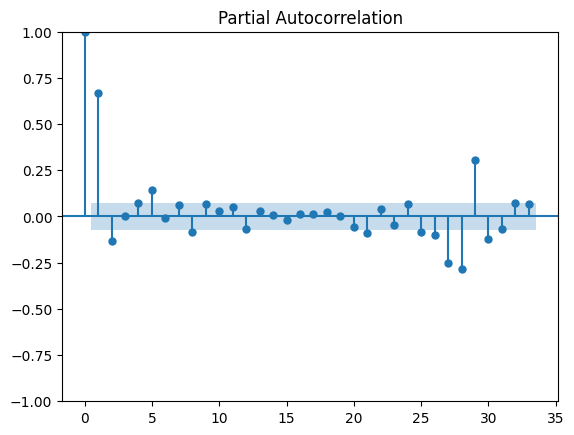

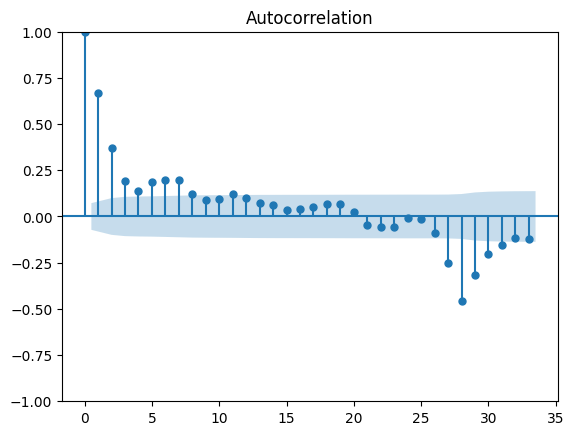

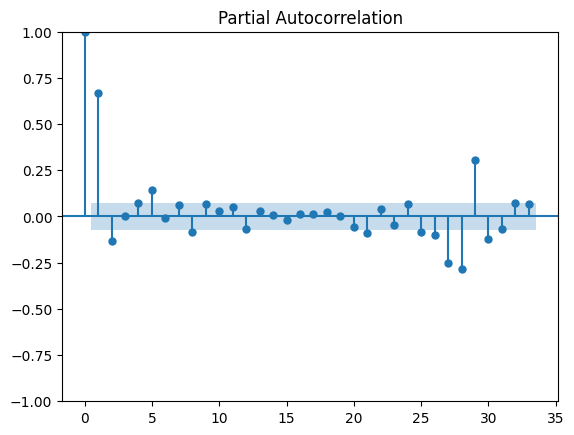

In [77]:
series = avg_views_by_lang["na"]
series_test = avg_views_by_lang_test["na"]
# plot_acf(series.dropna(), lags=30)
# plot_pacf(series.dropna(), lags=30)

series_diff28 = series.diff(periods=28)

series_diff7_7 = series_diff7.diff(periods=7)


plot_acf(series_diff28.dropna(), lags=33)
plot_pacf(series_diff28.dropna(), lags=33)

# plot_acf(series_diff7_7.dropna(), lags=30)
# plot_pacf(series_diff7_7.dropna(), lags=30)


# series_diff1 = series.diff(periods=1)
# series_diff1_7 = series_diff1.diff(periods=7)



# plot_acf(series_diff1_7.dropna(), lags=30)
# plot_pacf(series_diff1_7.dropna(), lags=30)

d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


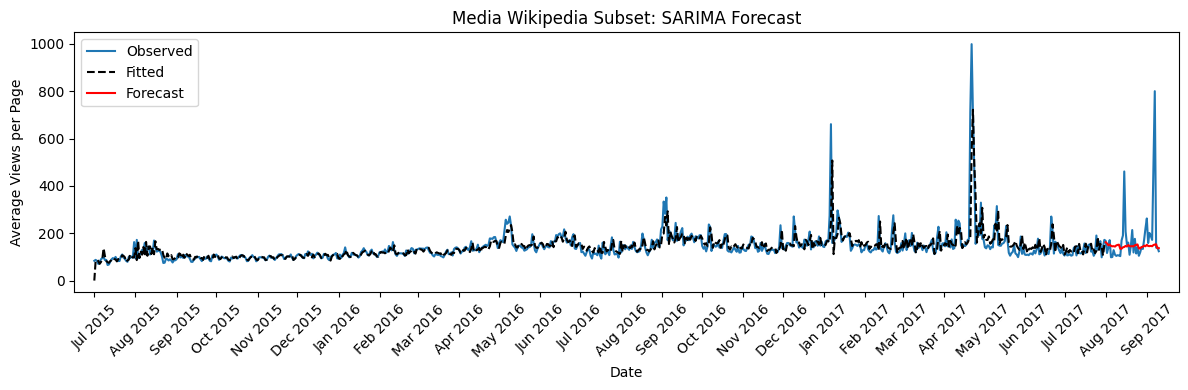

In [19]:
#Media Subset

series = avg_views_by_lang["na"]
series_test = avg_views_by_lang_test["na"]

# Fit SARIMA model
model = SARIMAX(series, order=(1,1,2), seasonal_order=(1,1,2,7))
fit = model.fit()
fitted_values = fit.fittedvalues

# Forecast next 41 days
forecast = fit.forecast(steps=41)

series_combined = pd.concat([series, series_test])

# Plot forecast vs. history
plt.figure(figsize=(12,4))
plt.plot(series_combined.index, series_combined, label="Observed")
plt.plot(series.index, fitted_values, label="Fitted", color="black", linestyle="--")
plt.plot(forecast.index, forecast, label="Forecast", color="red")
plt.legend()
plt.ylabel('Average Views per Page')
plt.xlabel('Date')
plt.title('Media Wikipedia Subset: SARIMA Forecast')

ax = plt.gca()

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)

delta = timedelta(days=15)
ax.set_xlim([train_dates.min() - delta, forecast.index.max() + delta])


plt.tight_layout()
plt.show()


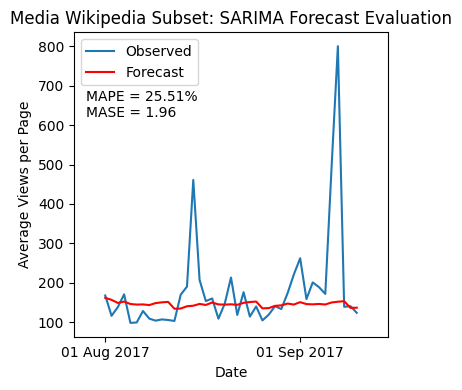

In [14]:
mape = np.mean(np.abs((series_test - forecast) / series_test)) * 100
mase = np.mean(np.abs(series_test - forecast))/np.mean(np.abs(series.values[7:] - series.values[:-7]))

plt.figure(figsize=(4,4))
plt.plot(series_test.index, series_test, label="Observed")
plt.plot(forecast.index, forecast, label=f"Forecast", color="red")
plt.legend(loc="upper left")
plt.title('Media Wikipedia Subset: SARIMA Forecast Evaluation')
plt.ylabel('Average Views per Page')
plt.xlabel('Date')


ax = plt.gca()

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))  # show day + month + year

#plt.xticks(rotation=45)

delta = timedelta(days=5)
ax.set_xlim([series_test.index.min() - delta, series_test.index.max() + delta])

plt.text(
    0.04, 0.81,                     # position in axes coordinates (left, top)
    f"MAPE = {mape:.2f}%\nMASE = {mase:.2f}",          # text
    transform=ax.transAxes,          # use axes coordinates
    verticalalignment='top'
)


plt.tight_layout()
plt.show()

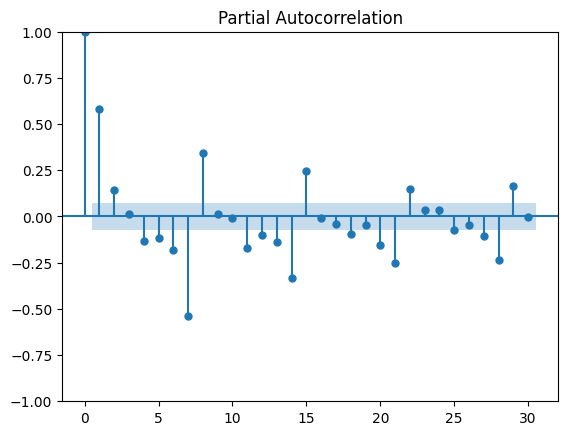

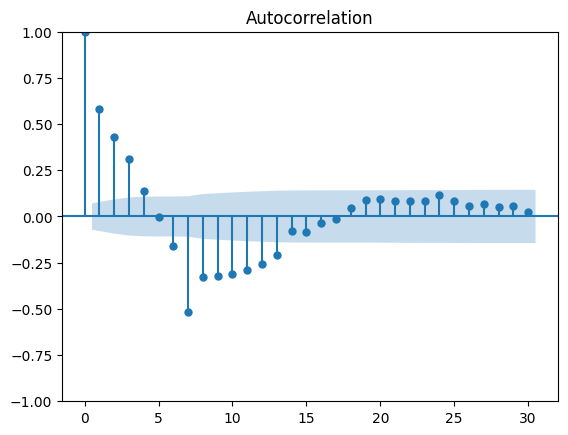

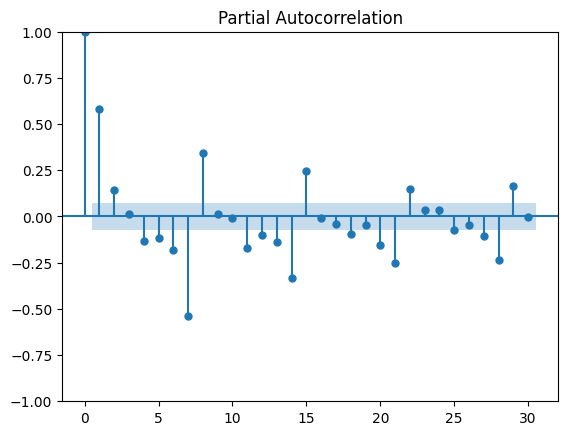

In [85]:
series = avg_views_by_lang["fr"]
series_test = avg_views_by_lang_test["fr"]
# plot_acf(series.dropna(), lags=30)
# plot_pacf(series.dropna(), lags=30)

series_diff7 = series.diff(periods=7)

series_diff7_7 = series_diff7.diff(periods=7)


# plot_acf(series_diff7.dropna(), lags=30)
# plot_pacf(series_diff7.dropna(), lags=30)

plot_acf(series_diff7_7.dropna(), lags=30)
plot_pacf(series_diff7_7.dropna(), lags=30)


# series_diff1 = series.diff(periods=1)
# series_diff1_7 = series_diff1.diff(periods=7)



# plot_acf(series_diff1_7.dropna(), lags=30)
# plot_pacf(series_diff1_7.dropna(), lags=30)

d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


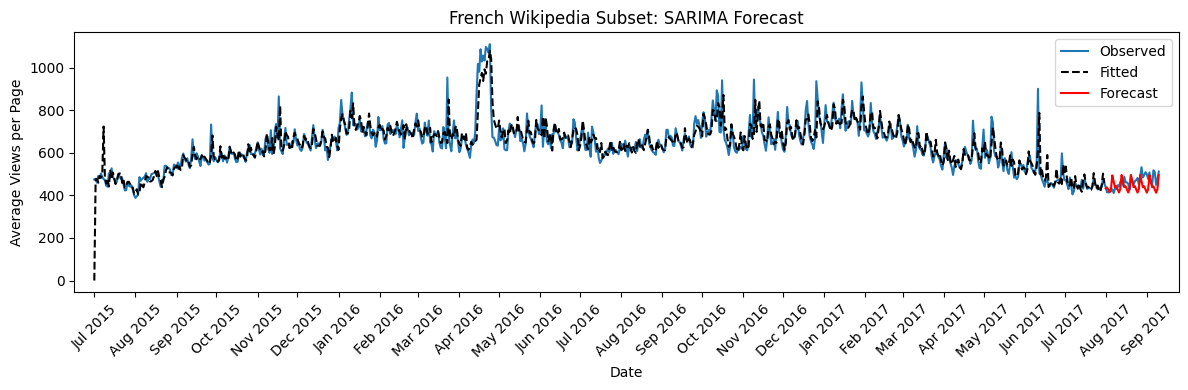

In [20]:
#French Subset

series = avg_views_by_lang["fr"]
series_test = avg_views_by_lang_test["fr"]

# Fit SARIMA model
model = SARIMAX(series, order=(1,1,1), seasonal_order=(1,1,1,7))
fit = model.fit()
fitted_values = fit.fittedvalues

# Forecast next 41 days
forecast = fit.forecast(steps=41)

series_combined = pd.concat([series, series_test])

# Plot forecast vs. history
plt.figure(figsize=(12,4))
plt.plot(series_combined.index, series_combined, label="Observed")
plt.plot(series.index, fitted_values, label="Fitted", color="black", linestyle="--")
plt.plot(forecast.index, forecast, label="Forecast", color="red")
plt.legend()
plt.ylabel('Average Views per Page')
plt.xlabel('Date')
plt.title('French Wikipedia Subset: SARIMA Forecast')

ax = plt.gca()

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)

delta = timedelta(days=15)
ax.set_xlim([train_dates.min() - delta, forecast.index.max() + delta])


plt.tight_layout()
plt.show()


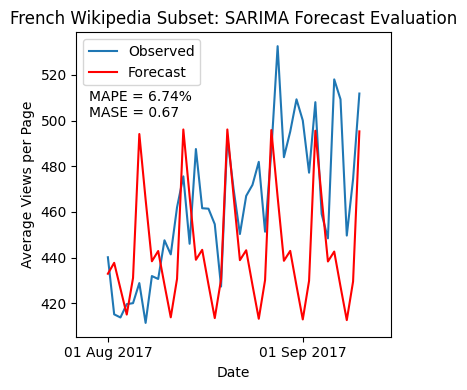

In [87]:
mape = np.mean(np.abs((series_test - forecast) / series_test)) * 100
mase = np.mean(np.abs(series_test - forecast))/np.mean(np.abs(series.values[7:] - series.values[:-7]))

plt.figure(figsize=(4,4))
plt.plot(series_test.index, series_test, label="Observed")
plt.plot(forecast.index, forecast, label=f"Forecast", color="red")
plt.legend(loc="upper left")
plt.title('French Wikipedia Subset: SARIMA Forecast Evaluation')
plt.ylabel('Average Views per Page')
plt.xlabel('Date')


ax = plt.gca()

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))  # show day + month + year

#plt.xticks(rotation=45)

delta = timedelta(days=5)
ax.set_xlim([series_test.index.min() - delta, series_test.index.max() + delta])

plt.text(
    0.04, 0.81,                     # position in axes coordinates (left, top)
    f"MAPE = {mape:.2f}%\nMASE = {mase:.2f}",          # text
    transform=ax.transAxes,          # use axes coordinates
    verticalalignment='top'
)


plt.tight_layout()
plt.show()

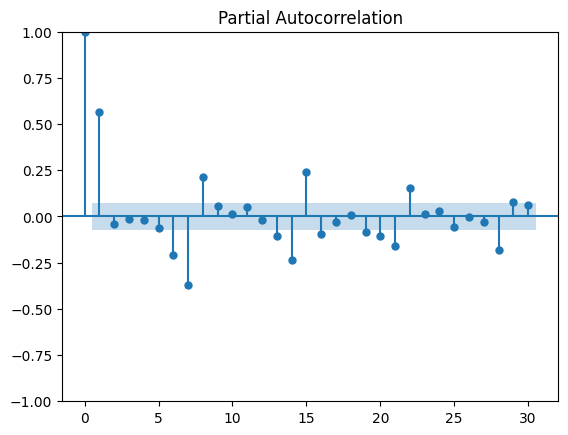

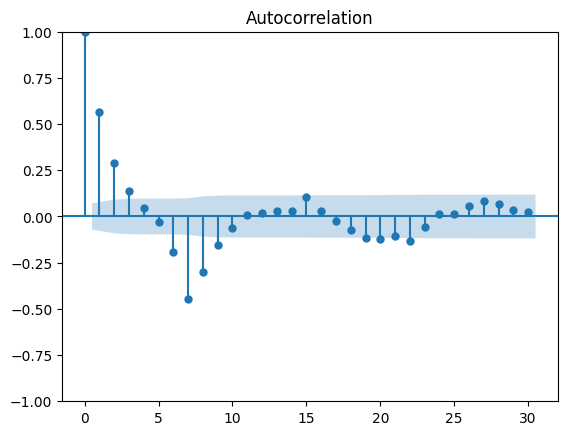

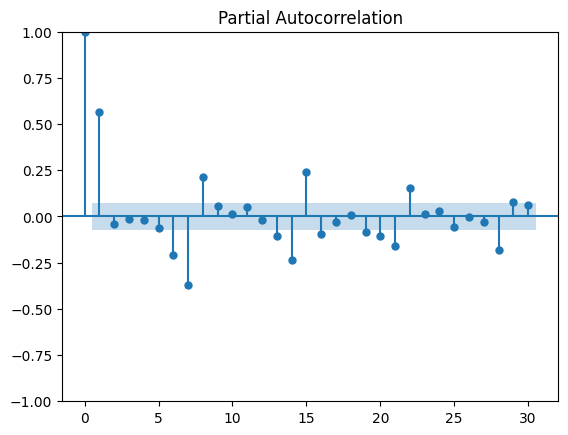

In [92]:
series = avg_views_by_lang["zh"]
series_test = avg_views_by_lang_test["zh"]
# plot_acf(series.dropna(), lags=30)
# plot_pacf(series.dropna(), lags=30)

series_diff7 = series.diff(periods=7)

# series_diff7_7 = series_diff7.diff(periods=7)


plot_acf(series_diff7.dropna(), lags=30)
plot_pacf(series_diff7.dropna(), lags=30)

# plot_acf(series_diff7_7.dropna(), lags=30)
# plot_pacf(series_diff7_7.dropna(), lags=30)


# series_diff1 = series.diff(periods=1)
# series_diff1_7 = series_diff1.diff(periods=7)



# plot_acf(series_diff1_7.dropna(), lags=30)
# plot_pacf(series_diff1_7.dropna(), lags=30)

d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


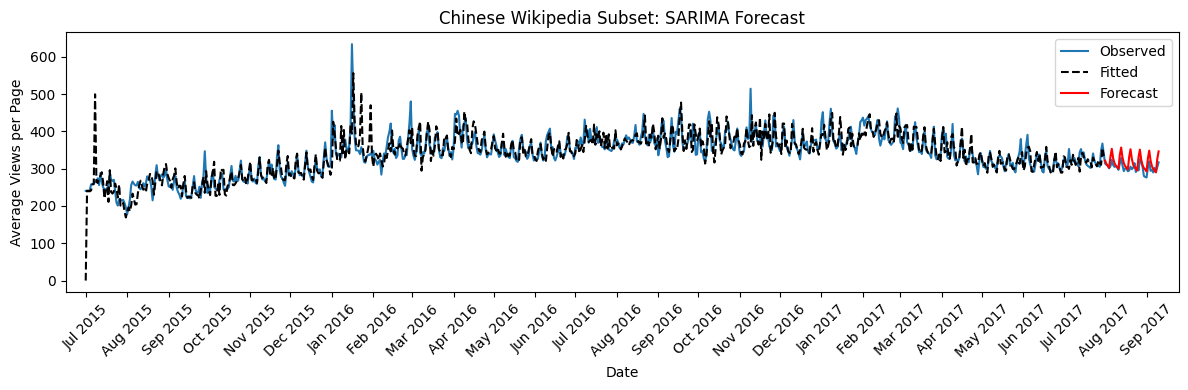

In [21]:
#Chinese subset

series = avg_views_by_lang["zh"]
series_test = avg_views_by_lang_test["zh"]

# Fit SARIMA model
model = SARIMAX(series, order=(1,1,1), seasonal_order=(1,2,1,7))
fit = model.fit()
fitted_values = fit.fittedvalues

# Forecast next 41 days
forecast = fit.forecast(steps=41)

series_combined = pd.concat([series, series_test])

# Plot forecast vs. history
plt.figure(figsize=(12,4))
plt.plot(series_combined.index, series_combined, label="Observed")
plt.plot(series.index, fitted_values, label="Fitted", color="black", linestyle="--")
plt.plot(forecast.index, forecast, label="Forecast", color="red")
plt.legend()
plt.ylabel('Average Views per Page')
plt.xlabel('Date')
plt.title('Chinese Wikipedia Subset: SARIMA Forecast')

ax = plt.gca()

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)

delta = timedelta(days=15)
ax.set_xlim([train_dates.min() - delta, forecast.index.max() + delta])


plt.tight_layout()
plt.show()


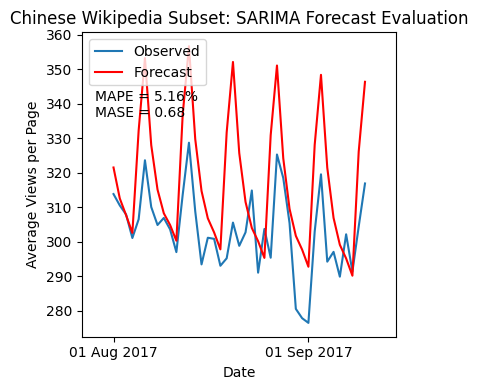

In [94]:
mape = np.mean(np.abs((series_test - forecast) / series_test)) * 100
mase = np.mean(np.abs(series_test - forecast))/np.mean(np.abs(series.values[7:] - series.values[:-7]))

plt.figure(figsize=(4,4))
plt.plot(series_test.index, series_test, label="Observed")
plt.plot(forecast.index, forecast, label=f"Forecast", color="red")
plt.legend(loc="upper left")
plt.title('Chinese Wikipedia Subset: SARIMA Forecast Evaluation')
plt.ylabel('Average Views per Page')
plt.xlabel('Date')


ax = plt.gca()

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))  # show day + month + year

#plt.xticks(rotation=45)

delta = timedelta(days=5)
ax.set_xlim([series_test.index.min() - delta, series_test.index.max() + delta])

plt.text(
    0.04, 0.81,                     # position in axes coordinates (left, top)
    f"MAPE = {mape:.2f}%\nMASE = {mase:.2f}",          # text
    transform=ax.transAxes,          # use axes coordinates
    verticalalignment='top'
)


plt.tight_layout()
plt.show()

In [ ]:
#labels={'en':'English','ja':'Japanese','de':'German',
#        'na':'Media','fr':'French','zh':'Chinese',
#        'ru':'Russian','es':'Spanish'
#       }

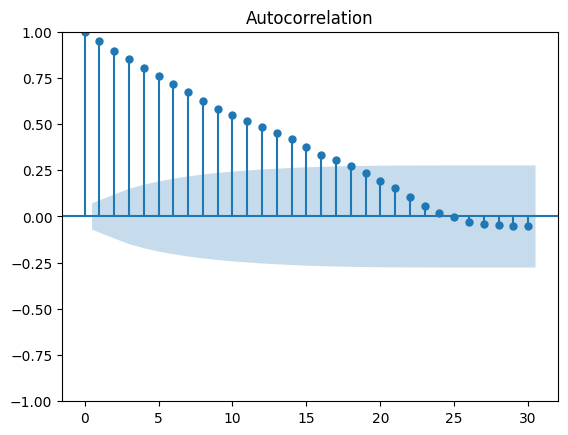

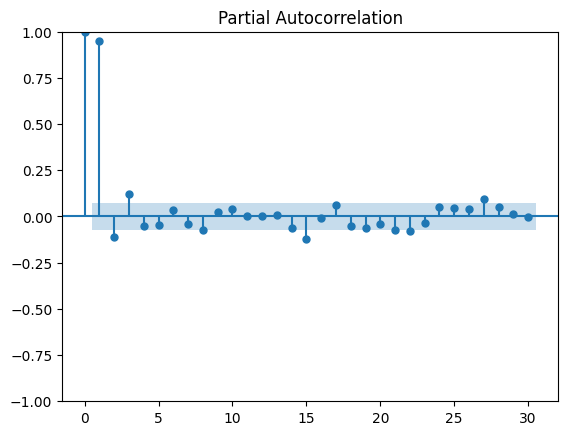

In [95]:
series = avg_views_by_lang["ru"]
series_test = avg_views_by_lang_test["ru"]
plot_acf(series.dropna(), lags=30)
plot_pacf(series.dropna(), lags=30)

series_diff7 = series.diff(periods=7)

# series_diff7_7 = series_diff7.diff(periods=7)


# plot_acf(series_diff7.dropna(), lags=30)
# plot_pacf(series_diff7.dropna(), lags=30)

# plot_acf(series_diff7_7.dropna(), lags=30)
# plot_pacf(series_diff7_7.dropna(), lags=30)


# series_diff1 = series.diff(periods=1)
# series_diff1_7 = series_diff1.diff(periods=7)



# plot_acf(series_diff1_7.dropna(), lags=30)
# plot_pacf(series_diff1_7.dropna(), lags=30)

d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


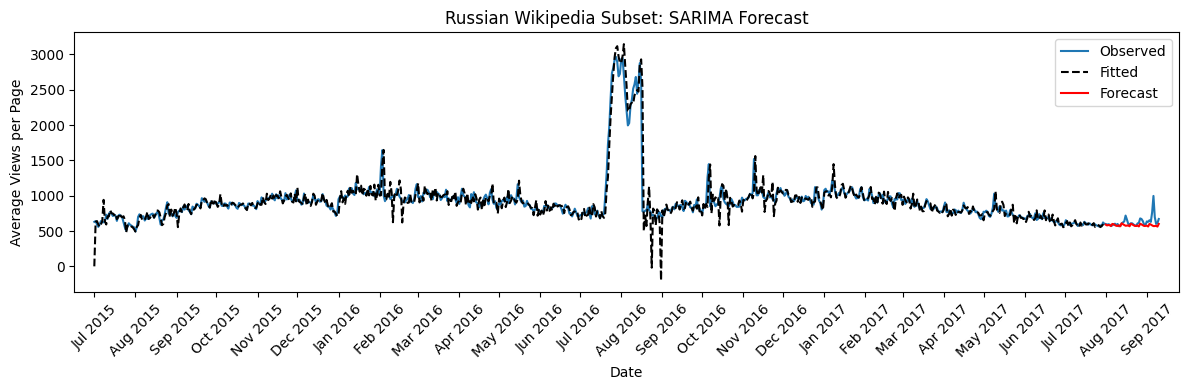

In [22]:
#Russian Subset

series = avg_views_by_lang["ru"]
series_test = avg_views_by_lang_test["ru"]

# Fit SARIMA model
model = SARIMAX(series, order=(1,1,0), seasonal_order=(1,1,0,7))
fit = model.fit()
fitted_values = fit.fittedvalues

# Forecast next 41 days
forecast = fit.forecast(steps=41)

series_combined = pd.concat([series, series_test])

# Plot forecast vs. history
plt.figure(figsize=(12,4))
plt.plot(series_combined.index, series_combined, label="Observed")
plt.plot(series.index, fitted_values, label="Fitted", color="black", linestyle="--")
plt.plot(forecast.index, forecast, label="Forecast", color="red")
plt.legend()
plt.ylabel('Average Views per Page')
plt.xlabel('Date')
plt.title('Russian Wikipedia Subset: SARIMA Forecast')

ax = plt.gca()

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)

delta = timedelta(days=15)
ax.set_xlim([train_dates.min() - delta, forecast.index.max() + delta])


plt.tight_layout()
plt.show()


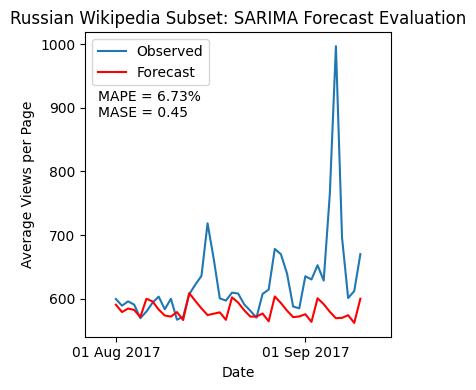

In [97]:
mape = np.mean(np.abs((series_test - forecast) / series_test)) * 100
mase = np.mean(np.abs(series_test - forecast))/np.mean(np.abs(series.values[7:] - series.values[:-7]))

plt.figure(figsize=(4,4))
plt.plot(series_test.index, series_test, label="Observed")
plt.plot(forecast.index, forecast, label=f"Forecast", color="red")
plt.legend(loc="upper left")
plt.title('Russian Wikipedia Subset: SARIMA Forecast Evaluation')
plt.ylabel('Average Views per Page')
plt.xlabel('Date')


ax = plt.gca()

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))  # show day + month + year

#plt.xticks(rotation=45)

delta = timedelta(days=5)
ax.set_xlim([series_test.index.min() - delta, series_test.index.max() + delta])

plt.text(
    0.04, 0.81,                     # position in axes coordinates (left, top)
    f"MAPE = {mape:.2f}%\nMASE = {mase:.2f}",          # text
    transform=ax.transAxes,          # use axes coordinates
    verticalalignment='top'
)


plt.tight_layout()
plt.show()

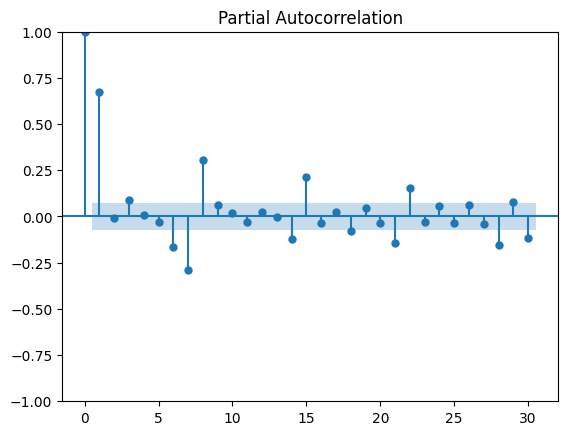

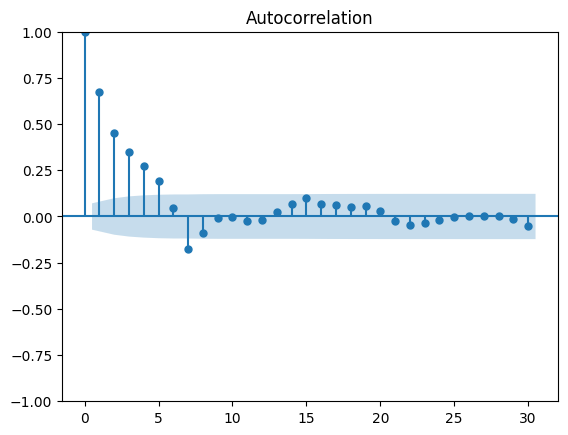

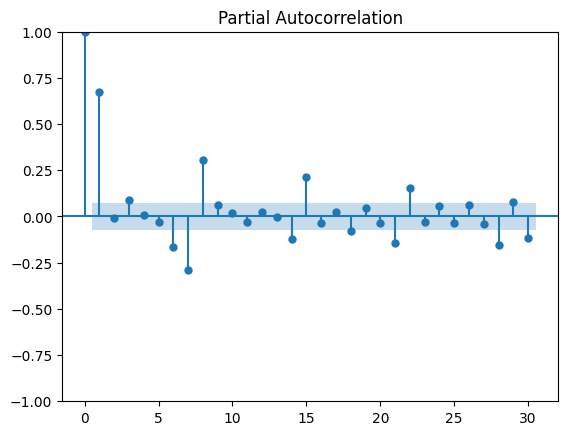

In [10]:
series = avg_views_by_lang["es"]
series_test = avg_views_by_lang_test["es"]
# plot_acf(series.dropna(), lags=30)
# plot_pacf(series.dropna(), lags=30)

series_diff7 = series.diff(periods=7)

# series_diff7_7 = series_diff7.diff(periods=7)


plot_acf(series_diff7.dropna(), lags=30)
plot_pacf(series_diff7.dropna(), lags=30)

# plot_acf(series_diff7_7.dropna(), lags=30)
# plot_pacf(series_diff7_7.dropna(), lags=30)


# series_diff1 = series.diff(periods=1)
# series_diff1_7 = series_diff1.diff(periods=7)



# plot_acf(series_diff1_7.dropna(), lags=30)
# plot_pacf(series_diff1_7.dropna(), lags=30)

d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Dokumenty\Internship\Time Series\time-series-analysis\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn(

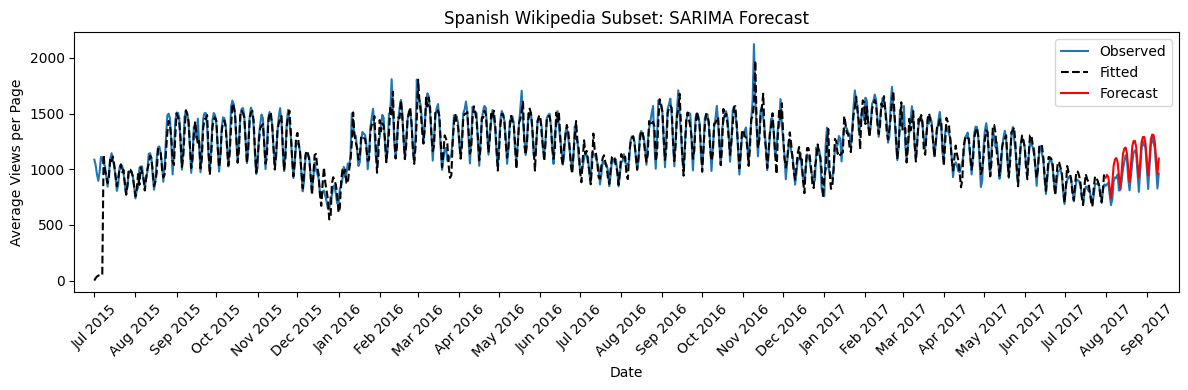

In [23]:
#Spanish Subset

series = avg_views_by_lang["es"]
series_test = avg_views_by_lang_test["es"]

# Fit SARIMA model
model = SARIMAX(series, order=(2,0,1), seasonal_order=(2,1,1,7))
fit = model.fit()
fitted_values = fit.fittedvalues

# Forecast next 41 days
forecast = fit.forecast(steps=41)

series_combined = pd.concat([series, series_test])

# Plot forecast vs. history
plt.figure(figsize=(12,4))
plt.plot(series_combined.index, series_combined, label="Observed")
plt.plot(series.index, fitted_values, label="Fitted", color="black", linestyle="--")
plt.plot(forecast.index, forecast, label="Forecast", color="red")
plt.legend()
plt.ylabel('Average Views per Page')
plt.xlabel('Date')
plt.title('Spanish Wikipedia Subset: SARIMA Forecast')

ax = plt.gca()

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)

delta = timedelta(days=15)
ax.set_xlim([train_dates.min() - delta, forecast.index.max() + delta])


plt.tight_layout()
plt.show()

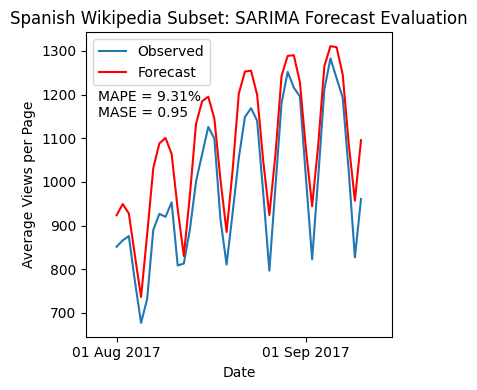

In [12]:
mape = np.mean(np.abs((series_test - forecast) / series_test)) * 100
mase = np.mean(np.abs(series_test - forecast))/np.mean(np.abs(series.values[7:] - series.values[:-7]))

plt.figure(figsize=(4,4))
plt.plot(series_test.index, series_test, label="Observed")
plt.plot(forecast.index, forecast, label=f"Forecast", color="red")
plt.legend(loc="upper left")
plt.title('Spanish Wikipedia Subset: SARIMA Forecast Evaluation')
plt.ylabel('Average Views per Page')
plt.xlabel('Date')


ax = plt.gca()

ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))  # show day + month + year

#plt.xticks(rotation=45)

delta = timedelta(days=5)
ax.set_xlim([series_test.index.min() - delta, series_test.index.max() + delta])

plt.text(
    0.04, 0.81,                     # position in axes coordinates (left, top)
    f"MAPE = {mape:.2f}%\nMASE = {mase:.2f}",          # text
    transform=ax.transAxes,          # use axes coordinates
    verticalalignment='top'
)


plt.tight_layout()
plt.show()

08:37:59 - cmdstanpy - INFO - Chain [1] start processing
08:37:59 - cmdstanpy - INFO - Chain [1] done processing


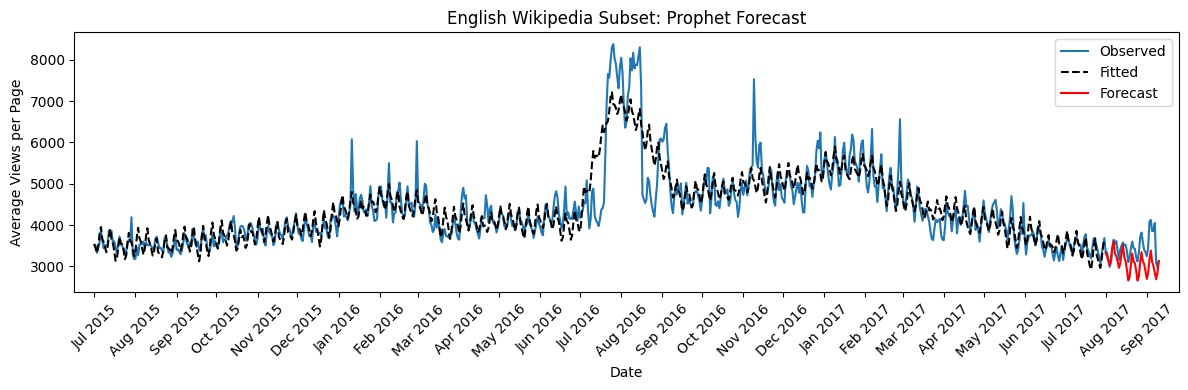

In [16]:
series = avg_views_by_lang["en"]
series_test = avg_views_by_lang_test["en"]
df_prophet = series.reset_index()       # converts index to a column
df_prophet.columns = ['ds', 'y']       # rename columns for Prophet

model = Prophet(yearly_seasonality=False, changepoint_prior_scale=1)
model.add_seasonality(
    name='monthly',
    period=30.5,      # length of one cycle in days
    fourier_order=5   # controls smoothness / complexity
)
model.fit(df_prophet)

future = model.make_future_dataframe(periods=41)
forecast = model.predict(future)

fitted_values = forecast.iloc[:len(series)]['yhat']
forecast_future = forecast.iloc[-len(series_test):]

series_combined = pd.concat([series, series_test])

plt.figure(figsize=(12,4))

# Plot observed
plt.plot(series_combined.index, series_combined, label="Observed", color='C0')

# Plot Prophet model
plt.plot(series.index, fitted_values, label="Fitted", color="black", linestyle="--")

# Plot Prophet forecast (last 41 days only)
plt.plot(forecast_future['ds'], forecast_future['yhat'], label="Forecast", color="red")

plt.legend()
plt.ylabel('Average Views per Page')
plt.xlabel('Date')
plt.title('English Wikipedia Subset: Prophet Forecast')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

delta = timedelta(days=15)
ax.set_xlim([train_dates.min() - delta, forecast['ds'].max() + delta])

plt.tight_layout()
plt.show()

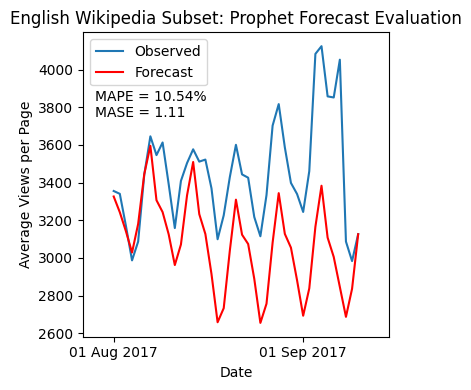

In [77]:
# Align forecasted values with test set
y_pred = forecast_future['yhat'].values
y_true = series_test.values

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mase = np.mean(np.abs(y_true - y_pred)) / np.mean(np.abs(series.values[7:] - series.values[:-7]))

plt.figure(figsize=(4,4))

# Observed
plt.plot(series_test.index, series_test, label="Observed")

# Prophet forecast
plt.plot(forecast_future['ds'], forecast_future['yhat'], label="Forecast", color="red")

plt.legend(loc="upper left")
plt.title('English Wikipedia Subset: Prophet Forecast Evaluation')
plt.ylabel('Average Views per Page')
plt.xlabel('Date')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))

delta = timedelta(days=5)
ax.set_xlim([series_test.index.min() - delta, series_test.index.max() + delta])

# Add metrics on the plot
plt.text(
    0.04, 0.81,
    f"MAPE = {mape:.2f}%\nMASE = {mase:.2f}",
    transform=ax.transAxes,
    verticalalignment='top'
)

plt.tight_layout()
plt.show()

08:38:21 - cmdstanpy - INFO - Chain [1] start processing
08:38:21 - cmdstanpy - INFO - Chain [1] done processing


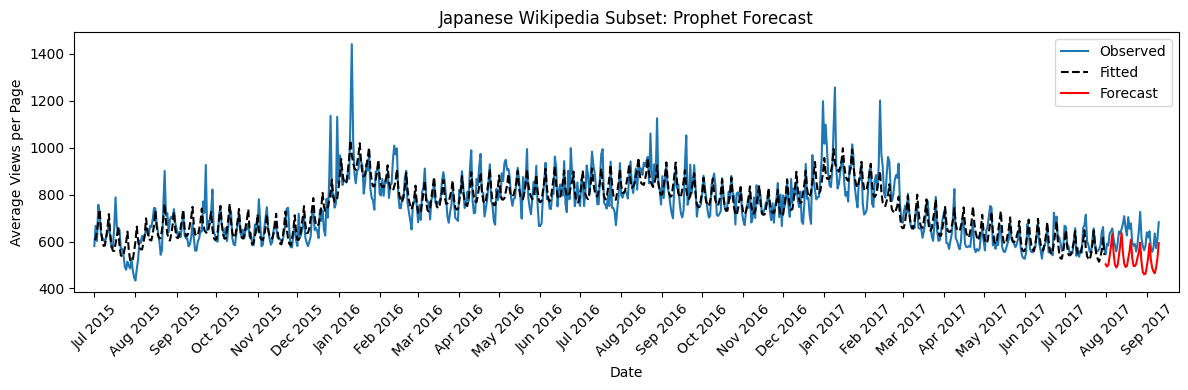

In [17]:
series = avg_views_by_lang["ja"]
series_test = avg_views_by_lang_test["ja"]
df_prophet = series.reset_index()       # converts index to a column
df_prophet.columns = ['ds', 'y']       # rename columns for Prophet

model = Prophet(yearly_seasonality=False, changepoint_prior_scale=1)
model.add_seasonality(
    name='monthly',
    period=30.5,      # length of one cycle in days
    fourier_order=5   # controls smoothness / complexity
)
model.fit(df_prophet)

future = model.make_future_dataframe(periods=41)
forecast = model.predict(future)

fitted_values = forecast.iloc[:len(series)]['yhat']
forecast_future = forecast.iloc[-len(series_test):]

series_combined = pd.concat([series, series_test])

plt.figure(figsize=(12,4))

# Plot observed
plt.plot(series_combined.index, series_combined, label="Observed", color='C0')

# Plot Prophet model
plt.plot(series.index, fitted_values, label="Fitted", color="black", linestyle="--")

# Plot Prophet forecast (last 41 days only)
plt.plot(forecast_future['ds'], forecast_future['yhat'], label="Forecast", color="red")

plt.legend()
plt.ylabel('Average Views per Page')
plt.xlabel('Date')
plt.title('Japanese Wikipedia Subset: Prophet Forecast')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

delta = timedelta(days=15)
ax.set_xlim([train_dates.min() - delta, forecast['ds'].max() + delta])

plt.tight_layout()
plt.show()

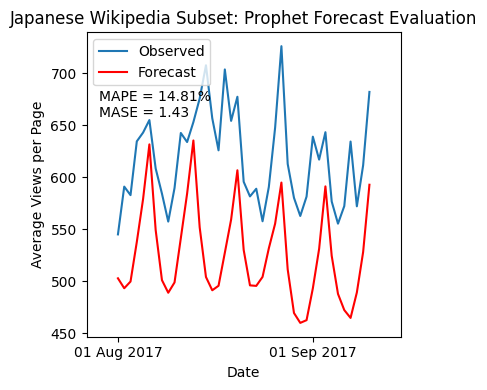

In [79]:
# Align forecasted values with test set
y_pred = forecast_future['yhat'].values
y_true = series_test.values

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mase = np.mean(np.abs(y_true - y_pred)) / np.mean(np.abs(series.values[7:] - series.values[:-7]))

plt.figure(figsize=(4,4))

# Observed
plt.plot(series_test.index, series_test, label="Observed")

# Prophet forecast
plt.plot(forecast_future['ds'], forecast_future['yhat'], label="Forecast", color="red")

plt.legend(loc="upper left")
plt.title('Japanese Wikipedia Subset: Prophet Forecast Evaluation')
plt.ylabel('Average Views per Page')
plt.xlabel('Date')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))

delta = timedelta(days=5)
ax.set_xlim([series_test.index.min() - delta, series_test.index.max() + delta])

# Add metrics on the plot
plt.text(
    0.04, 0.81,
    f"MAPE = {mape:.2f}%\nMASE = {mase:.2f}",
    transform=ax.transAxes,
    verticalalignment='top'
)

plt.tight_layout()
plt.show()

08:42:47 - cmdstanpy - INFO - Chain [1] start processing
08:42:47 - cmdstanpy - INFO - Chain [1] done processing


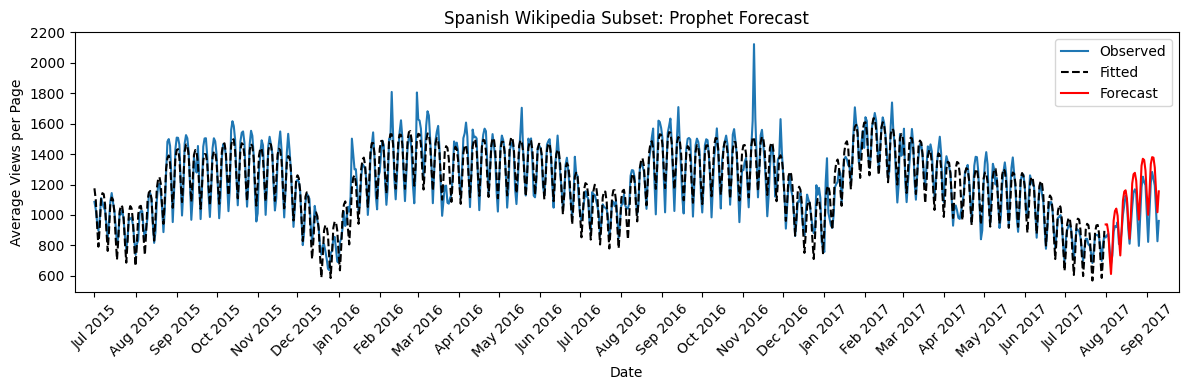

In [26]:
series = avg_views_by_lang["es"]
series_test = avg_views_by_lang_test["es"]
df_prophet = series.reset_index()       # converts index to a column
df_prophet.columns = ['ds', 'y']       # rename columns for Prophet

model = Prophet(yearly_seasonality=True, changepoint_prior_scale=1)
model.add_seasonality(
    name='monthly',
    period=30.5,      # length of one cycle in days
    fourier_order=5   # controls smoothness / complexity
)
model.fit(df_prophet)

future = model.make_future_dataframe(periods=41)
forecast = model.predict(future)

fitted_values = forecast.iloc[:len(series)]['yhat']
forecast_future = forecast.iloc[-len(series_test):]

series_combined = pd.concat([series, series_test])

plt.figure(figsize=(12,4))

# Plot observed
plt.plot(series_combined.index, series_combined, label="Observed", color='C0')

# Plot Prophet model
plt.plot(series.index, fitted_values, label="Fitted", color="black", linestyle="--")

# Plot Prophet forecast (last 41 days only)
plt.plot(forecast_future['ds'], forecast_future['yhat'], label="Forecast", color="red")

plt.legend()
plt.ylabel('Average Views per Page')
plt.xlabel('Date')
plt.title('Spanish Wikipedia Subset: Prophet Forecast')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

delta = timedelta(days=15)
ax.set_xlim([train_dates.min() - delta, forecast['ds'].max() + delta])

plt.tight_layout()
plt.show()

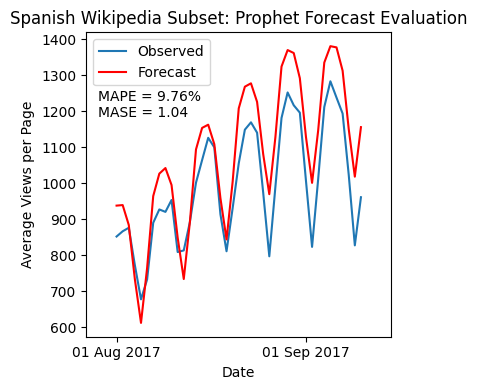

In [27]:
# Align forecasted values with test set
y_pred = forecast_future['yhat'].values
y_true = series_test.values

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mase = np.mean(np.abs(y_true - y_pred)) / np.mean(np.abs(series.values[7:] - series.values[:-7]))

plt.figure(figsize=(4,4))

# Observed
plt.plot(series_test.index, series_test, label="Observed")

# Prophet forecast
plt.plot(forecast_future['ds'], forecast_future['yhat'], label="Forecast", color="red")

plt.legend(loc="upper left")
plt.title('Spanish Wikipedia Subset: Prophet Forecast Evaluation')
plt.ylabel('Average Views per Page')
plt.xlabel('Date')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))

delta = timedelta(days=5)
ax.set_xlim([series_test.index.min() - delta, series_test.index.max() + delta])

# Add metrics on the plot
plt.text(
    0.04, 0.81,
    f"MAPE = {mape:.2f}%\nMASE = {mase:.2f}",
    transform=ax.transAxes,
    verticalalignment='top'
)

plt.tight_layout()
plt.show()

In [ ]:
# labels={'en':'English','ja':'Japanese','de':'German',
#         'na':'Media','fr':'French','zh':'Chinese',
#         'ru':'Russian','es':'Spanish'
#        }

08:41:08 - cmdstanpy - INFO - Chain [1] start processing
08:41:08 - cmdstanpy - INFO - Chain [1] done processing


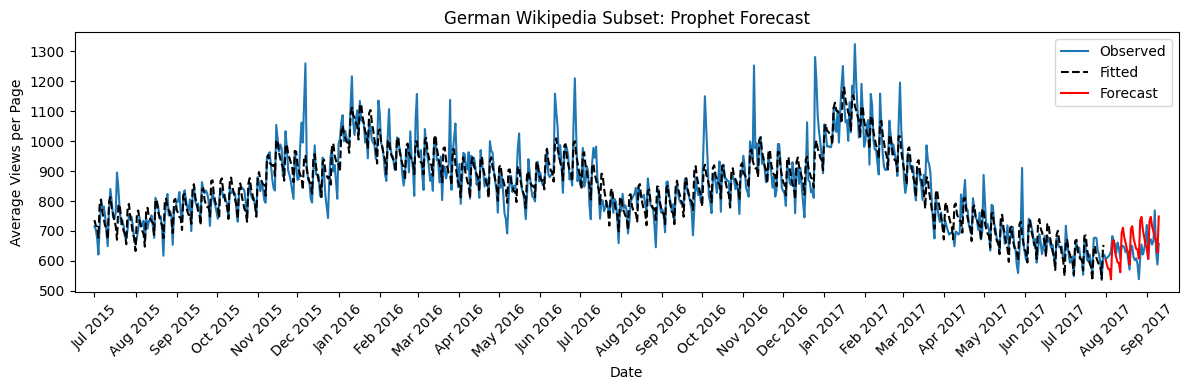

In [ ]:
series = avg_views_by_lang["de"]
series_test = avg_views_by_lang_test["de"]
df_prophet = series.reset_index()       # converts index to a column
df_prophet.columns = ['ds', 'y']       # rename columns for Prophet

model = Prophet(yearly_seasonality=True, changepoint_prior_scale=1)
model.add_seasonality(
    name='monthly',
    period=30.5,      # length of one cycle in days
    fourier_order=5   # controls smoothness / complexity
)
model.fit(df_prophet)

future = model.make_future_dataframe(periods=41)
forecast = model.predict(future)

fitted_values = forecast.iloc[:len(series)]['yhat']
forecast_future = forecast.iloc[-len(series_test):]

series_combined = pd.concat([series, series_test])

plt.figure(figsize=(12,4))

# Plot observed
plt.plot(series_combined.index, series_combined, label="Observed", color='C0')

# Plot Prophet model
plt.plot(series.index, fitted_values, label="Fitted", color="black", linestyle="--")

# Plot Prophet forecast (last 41 days only)
plt.plot(forecast_future['ds'], forecast_future['yhat'], label="Forecast", color="red")

plt.legend()
plt.ylabel('Average Views per Page')
plt.xlabel('Date')
plt.title('German Wikipedia Subset: Prophet Forecast')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

delta = timedelta(days=15)
ax.set_xlim([train_dates.min() - delta, forecast['ds'].max() + delta])

plt.tight_layout()
plt.show()

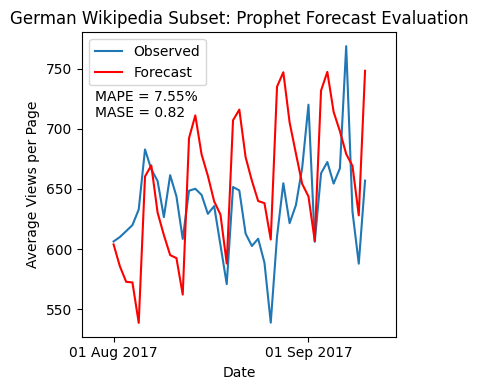

In [25]:
# Align forecasted values with test set
y_pred = forecast_future['yhat'].values
y_true = series_test.values

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mase = np.mean(np.abs(y_true - y_pred)) / np.mean(np.abs(series.values[7:] - series.values[:-7]))

plt.figure(figsize=(4,4))

# Observed
plt.plot(series_test.index, series_test, label="Observed")

# Prophet forecast
plt.plot(forecast_future['ds'], forecast_future['yhat'], label="Forecast", color="red")

plt.legend(loc="upper left")
plt.title('German Wikipedia Subset: Prophet Forecast Evaluation')
plt.ylabel('Average Views per Page')
plt.xlabel('Date')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))

delta = timedelta(days=5)
ax.set_xlim([series_test.index.min() - delta, series_test.index.max() + delta])

# Add metrics on the plot
plt.text(
    0.04, 0.81,
    f"MAPE = {mape:.2f}%\nMASE = {mase:.2f}",
    transform=ax.transAxes,
    verticalalignment='top'
)

plt.tight_layout()
plt.show()

09:00:05 - cmdstanpy - INFO - Chain [1] start processing
09:00:05 - cmdstanpy - INFO - Chain [1] done processing


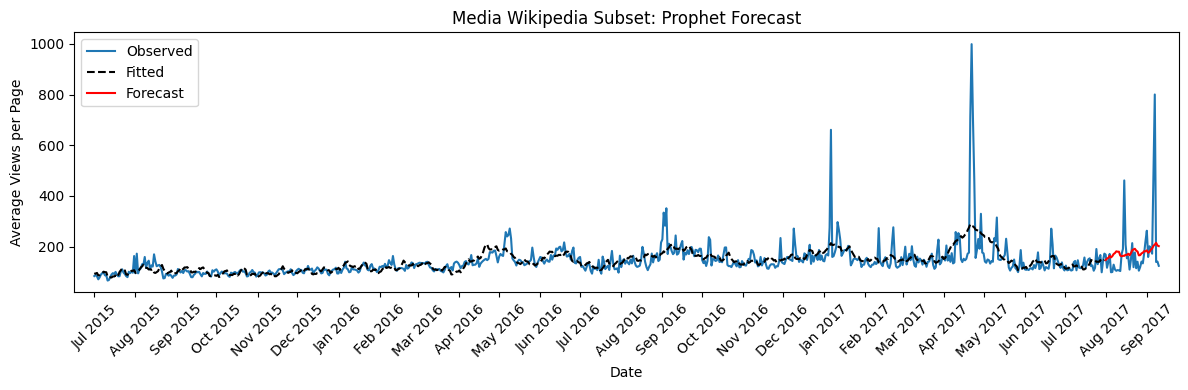

In [36]:
series = avg_views_by_lang["na"]
series_test = avg_views_by_lang_test["na"]
df_prophet = series.reset_index()       # converts index to a column
df_prophet.columns = ['ds', 'y']       # rename columns for Prophet

model = Prophet(yearly_seasonality=True, changepoint_prior_scale=1)
model.add_seasonality(
    name='monthly',
    period=30.5,      # length of one cycle in days
    fourier_order=5   # controls smoothness / complexity
)
model.fit(df_prophet)

future = model.make_future_dataframe(periods=41)
forecast = model.predict(future)

fitted_values = forecast.iloc[:len(series)]['yhat']
forecast_future = forecast.iloc[-len(series_test):]

series_combined = pd.concat([series, series_test])

plt.figure(figsize=(12,4))

# Plot observed
plt.plot(series_combined.index, series_combined, label="Observed", color='C0')

# Plot Prophet model
plt.plot(series.index, fitted_values, label="Fitted", color="black", linestyle="--")

# Plot Prophet forecast (last 41 days only)
plt.plot(forecast_future['ds'], forecast_future['yhat'], label="Forecast", color="red")

plt.legend()
plt.ylabel('Average Views per Page')
plt.xlabel('Date')
plt.title('Media Wikipedia Subset: Prophet Forecast')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

delta = timedelta(days=15)
ax.set_xlim([train_dates.min() - delta, forecast['ds'].max() + delta])

plt.tight_layout()
plt.show()

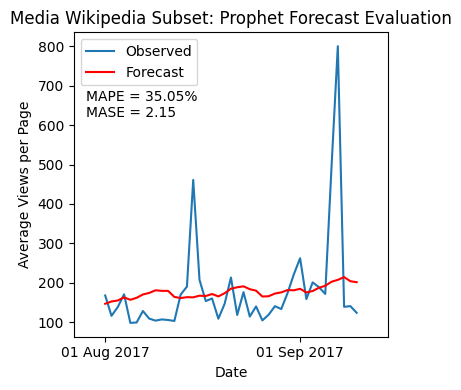

In [38]:
# Align forecasted values with test set
y_pred = forecast_future['yhat'].values
y_true = series_test.values

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mase = np.mean(np.abs(y_true - y_pred)) / np.mean(np.abs(series.values[7:] - series.values[:-7]))

plt.figure(figsize=(4,4))

# Observed
plt.plot(series_test.index, series_test, label="Observed")

# Prophet forecast
plt.plot(forecast_future['ds'], forecast_future['yhat'], label="Forecast", color="red")

plt.legend(loc="upper left")
plt.title('Media Wikipedia Subset: Prophet Forecast Evaluation')
plt.ylabel('Average Views per Page')
plt.xlabel('Date')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))

delta = timedelta(days=5)
ax.set_xlim([series_test.index.min() - delta, series_test.index.max() + delta])

# Add metrics on the plot
plt.text(
    0.04, 0.81,
    f"MAPE = {mape:.2f}%\nMASE = {mase:.2f}",
    transform=ax.transAxes,
    verticalalignment='top'
)

plt.tight_layout()
plt.show()

09:02:47 - cmdstanpy - INFO - Chain [1] start processing
09:02:47 - cmdstanpy - INFO - Chain [1] done processing


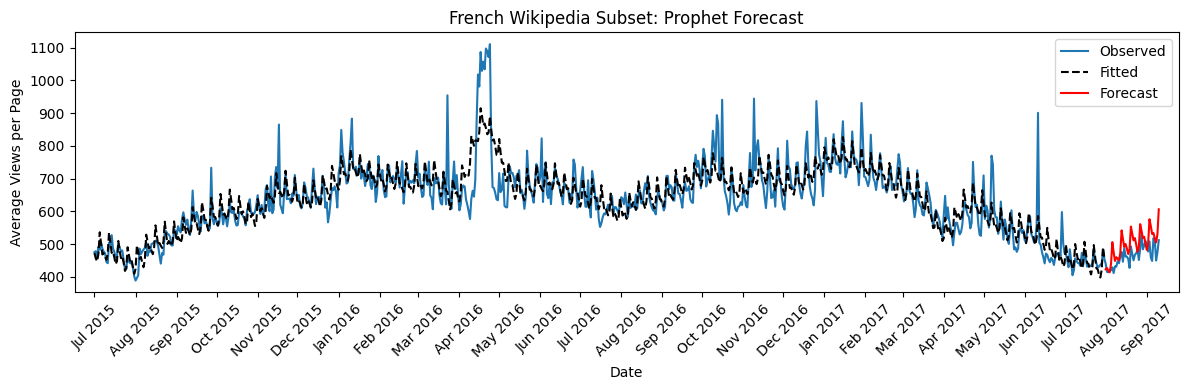

In [39]:
series = avg_views_by_lang["fr"]
series_test = avg_views_by_lang_test["fr"]
df_prophet = series.reset_index()       # converts index to a column
df_prophet.columns = ['ds', 'y']       # rename columns for Prophet

model = Prophet(yearly_seasonality=True, changepoint_prior_scale=1)
model.add_seasonality(
    name='monthly',
    period=30.5,      # length of one cycle in days
    fourier_order=5   # controls smoothness / complexity
)
model.fit(df_prophet)

future = model.make_future_dataframe(periods=41)
forecast = model.predict(future)

fitted_values = forecast.iloc[:len(series)]['yhat']
forecast_future = forecast.iloc[-len(series_test):]

series_combined = pd.concat([series, series_test])

plt.figure(figsize=(12,4))

# Plot observed
plt.plot(series_combined.index, series_combined, label="Observed", color='C0')

# Plot Prophet model
plt.plot(series.index, fitted_values, label="Fitted", color="black", linestyle="--")

# Plot Prophet forecast (last 41 days only)
plt.plot(forecast_future['ds'], forecast_future['yhat'], label="Forecast", color="red")

plt.legend()
plt.ylabel('Average Views per Page')
plt.xlabel('Date')
plt.title('French Wikipedia Subset: Prophet Forecast')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

delta = timedelta(days=15)
ax.set_xlim([train_dates.min() - delta, forecast['ds'].max() + delta])

plt.tight_layout()
plt.show()

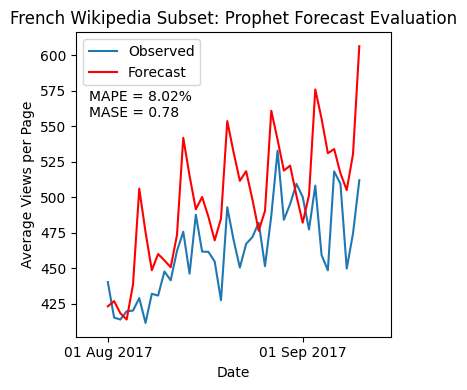

In [40]:
# Align forecasted values with test set
y_pred = forecast_future['yhat'].values
y_true = series_test.values

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mase = np.mean(np.abs(y_true - y_pred)) / np.mean(np.abs(series.values[7:] - series.values[:-7]))

plt.figure(figsize=(4,4))

# Observed
plt.plot(series_test.index, series_test, label="Observed")

# Prophet forecast
plt.plot(forecast_future['ds'], forecast_future['yhat'], label="Forecast", color="red")

plt.legend(loc="upper left")
plt.title('French Wikipedia Subset: Prophet Forecast Evaluation')
plt.ylabel('Average Views per Page')
plt.xlabel('Date')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))

delta = timedelta(days=5)
ax.set_xlim([series_test.index.min() - delta, series_test.index.max() + delta])

# Add metrics on the plot
plt.text(
    0.04, 0.81,
    f"MAPE = {mape:.2f}%\nMASE = {mase:.2f}",
    transform=ax.transAxes,
    verticalalignment='top'
)

plt.tight_layout()
plt.show()

09:05:09 - cmdstanpy - INFO - Chain [1] start processing
09:05:09 - cmdstanpy - INFO - Chain [1] done processing


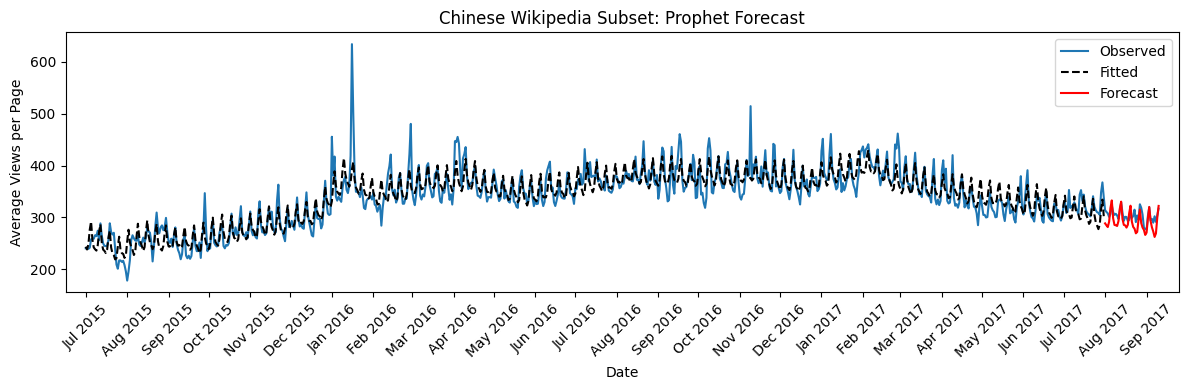

In [42]:
series = avg_views_by_lang["zh"]
series_test = avg_views_by_lang_test["zh"]
df_prophet = series.reset_index()       # converts index to a column
df_prophet.columns = ['ds', 'y']       # rename columns for Prophet

model = Prophet(yearly_seasonality=False, changepoint_prior_scale=1)
model.add_seasonality(
    name='monthly',
    period=30.5,      # length of one cycle in days
    fourier_order=5   # controls smoothness / complexity
)
model.fit(df_prophet)

future = model.make_future_dataframe(periods=41)
forecast = model.predict(future)

fitted_values = forecast.iloc[:len(series)]['yhat']
forecast_future = forecast.iloc[-len(series_test):]

series_combined = pd.concat([series, series_test])

plt.figure(figsize=(12,4))

# Plot observed
plt.plot(series_combined.index, series_combined, label="Observed", color='C0')

# Plot Prophet model
plt.plot(series.index, fitted_values, label="Fitted", color="black", linestyle="--")

# Plot Prophet forecast (last 41 days only)
plt.plot(forecast_future['ds'], forecast_future['yhat'], label="Forecast", color="red")

plt.legend()
plt.ylabel('Average Views per Page')
plt.xlabel('Date')
plt.title('Chinese Wikipedia Subset: Prophet Forecast')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

delta = timedelta(days=15)
ax.set_xlim([train_dates.min() - delta, forecast['ds'].max() + delta])

plt.tight_layout()
plt.show()

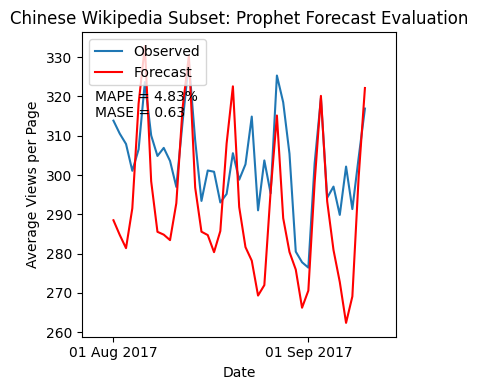

In [43]:
# Align forecasted values with test set
y_pred = forecast_future['yhat'].values
y_true = series_test.values

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mase = np.mean(np.abs(y_true - y_pred)) / np.mean(np.abs(series.values[7:] - series.values[:-7]))

plt.figure(figsize=(4,4))

# Observed
plt.plot(series_test.index, series_test, label="Observed")

# Prophet forecast
plt.plot(forecast_future['ds'], forecast_future['yhat'], label="Forecast", color="red")

plt.legend(loc="upper left")
plt.title('Chinese Wikipedia Subset: Prophet Forecast Evaluation')
plt.ylabel('Average Views per Page')
plt.xlabel('Date')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))

delta = timedelta(days=5)
ax.set_xlim([series_test.index.min() - delta, series_test.index.max() + delta])

# Add metrics on the plot
plt.text(
    0.04, 0.81,
    f"MAPE = {mape:.2f}%\nMASE = {mase:.2f}",
    transform=ax.transAxes,
    verticalalignment='top'
)

plt.tight_layout()
plt.show()

09:08:56 - cmdstanpy - INFO - Chain [1] start processing
09:08:56 - cmdstanpy - INFO - Chain [1] done processing


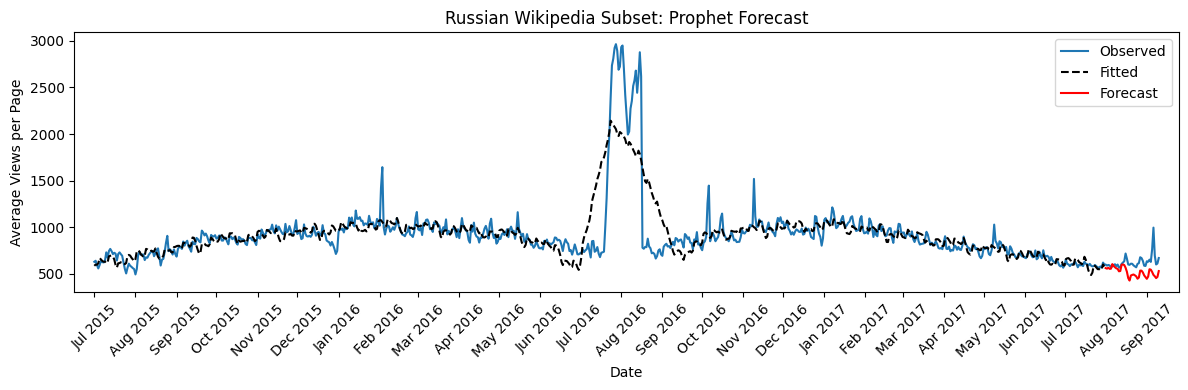

In [49]:
series = avg_views_by_lang["ru"]
series_test = avg_views_by_lang_test["ru"]
df_prophet = series.reset_index()       # converts index to a column
df_prophet.columns = ['ds', 'y']       # rename columns for Prophet

model = Prophet(yearly_seasonality=False, changepoint_prior_scale=1)
model.add_seasonality(
    name='monthly',
    period=30.5,      # length of one cycle in days
    fourier_order=5   # controls smoothness / complexity
)
model.fit(df_prophet)

future = model.make_future_dataframe(periods=41)
forecast = model.predict(future)

fitted_values = forecast.iloc[:len(series)]['yhat']
forecast_future = forecast.iloc[-len(series_test):]

series_combined = pd.concat([series, series_test])

plt.figure(figsize=(12,4))

# Plot observed
plt.plot(series_combined.index, series_combined, label="Observed", color='C0')

# Plot Prophet model
plt.plot(series.index, fitted_values, label="Fitted", color="black", linestyle="--")

# Plot Prophet forecast (last 41 days only)
plt.plot(forecast_future['ds'], forecast_future['yhat'], label="Forecast", color="red")

plt.legend()
plt.ylabel('Average Views per Page')
plt.xlabel('Date')
plt.title('Russian Wikipedia Subset: Prophet Forecast')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

delta = timedelta(days=15)
ax.set_xlim([train_dates.min() - delta, forecast['ds'].max() + delta])

plt.tight_layout()
plt.show()

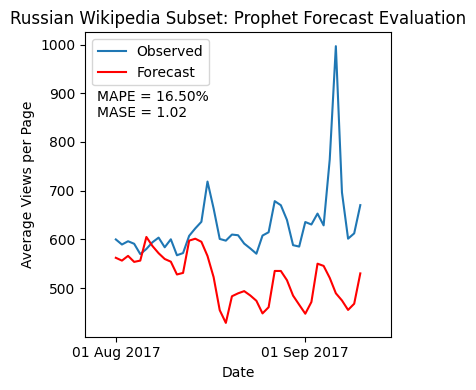

In [50]:
# Align forecasted values with test set
y_pred = forecast_future['yhat'].values
y_true = series_test.values

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mase = np.mean(np.abs(y_true - y_pred)) / np.mean(np.abs(series.values[7:] - series.values[:-7]))

plt.figure(figsize=(4,4))

# Observed
plt.plot(series_test.index, series_test, label="Observed")

# Prophet forecast
plt.plot(forecast_future['ds'], forecast_future['yhat'], label="Forecast", color="red")

plt.legend(loc="upper left")
plt.title('Russian Wikipedia Subset: Prophet Forecast Evaluation')
plt.ylabel('Average Views per Page')
plt.xlabel('Date')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))

delta = timedelta(days=5)
ax.set_xlim([series_test.index.min() - delta, series_test.index.max() + delta])

# Add metrics on the plot
plt.text(
    0.04, 0.81,
    f"MAPE = {mape:.2f}%\nMASE = {mase:.2f}",
    transform=ax.transAxes,
    verticalalignment='top'
)

plt.tight_layout()
plt.show()